# Add BED to ENSG_TPM

In [1]:
library(tidyverse)
library(ggplot2)
library(clusterProfiler)
library(biomaRt)
print("Loaded.")

setwd("/data/hodges_lab/Tim/nnRNA_TPM_EHGM/reference_files/")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



clusterProfiler v4.2.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter




[1] "Loaded."


## GM 

### Average reps

In [2]:
# Read in 
GM_ENSG_file_in_1 <- read_tsv("./ENCFF873VWU.tsv", col_names=TRUE, skip=0)
GM_ENSG_file_in_2 <- read_tsv("./ENCFF345SHY.tsv", col_names=TRUE, skip=0) 

Rows: 59526 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): gene_id, transcript_id(s)
dbl (15): length, effective_length, expected_count, TPM, FPKM, posterior_mea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 59526 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): gene_id, transcript_id(s)
dbl (15): length, effective_length, expected_count, TPM, FPKM, posterior_mea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# Filter to keep just ENSG rows
GM_ENSG_only_1 <- GM_ENSG_file_in_1 %>%
    filter("ENSG"==substr(gene_id, 1, 4))
GM_ENSG_only_2 <- GM_ENSG_file_in_2 %>%
    filter("ENSG"==substr(gene_id, 1, 4))

# Isolate columns we want 
GM_ENSG_TPM_1 <- GM_ENSG_only_1 %>%
    dplyr::select(gene_id, TPM) %>% # isolate gene_id_clean and TPM columns
    magrittr::set_colnames(c("ENSEMBL", "TPM")) # Rename these for easier merging and readibility 
GM_ENSG_TPM_2 <- GM_ENSG_only_2 %>%
    dplyr::select(gene_id, TPM) %>% # isolate gene_id_clean and TPM columns
    magrittr::set_colnames(c("ENSEMBL", "TPM")) # Rename these for easier merging and readibility 


# Average reps
GM_ENSG_TPM_merge12 <- merge(GM_ENSG_TPM_1, GM_ENSG_TPM_2, by = "ENSEMBL") %>% as_tibble()

GM_ENSG_TPM_avg12 <- GM_ENSG_TPM_merge12 %>% dplyr::mutate(TPM = rowMeans(dplyr::select(., TPM.x:TPM.y))) %>% dplyr::select(ENSEMBL, TPM)

In [172]:
write_tsv(GM_ENSG_TPM_avg12, "GM_ENSG_TPM_avg12.txt", col_names = TRUE)

### Biomart

In [4]:
# define biomart object
# mart <- useMart(biomart = "ensembl", dataset = "hsapiens_gene_ensembl")
mart <- useMart(biomart="ENSEMBL_MART_ENSEMBL", host="grch37.ensembl.org", path="/biomart/martservice", dataset="hsapiens_gene_ensembl")

ENSEMBL_to_GENESYMBOL <- getBM(attributes=c("ensembl_gene_id_version", "hgnc_symbol", "chromosome_name", "start_position", "end_position","strand"), filters = "ensembl_gene_id_version", values = GM_ENSG_TPM_avg12$ENSEMBL, mart= mart)

Warning message:
“Ensembl will soon enforce the use of https.
Ensure the 'host' argument includes "https://"”


### Convert ENSEMBL to GENE SYMBOL

In [5]:
nrow(GM_ENSG_TPM_avg12)
head(GM_ENSG_TPM_avg12, 3)

[1] 58780

ENSEMBL,TPM
<chr>,<dbl>
ENSG00000000003.14,0.090
ENSG00000000005.5,0.000
ENSG00000000419.12,19.935


In [6]:
GM_ENSG_TPM_avg12_noVersion <- GM_ENSG_TPM_avg12 %>% mutate(ENSG = gsub("\\..*", "", ENSEMBL))

In [7]:
ENSEMBLnoVersion_to_GENESYMBOL <- getBM(attributes=c("ensembl_gene_id", "hgnc_symbol", "chromosome_name", "start_position", "end_position","strand"), filters = "ensembl_gene_id", values = GM_ENSG_TPM_avg12_noVersion$ENSG, mart= mart)

nrow(ENSEMBLnoVersion_to_GENESYMBOL)
ENSEMBLnoVersion_to_GENESYMBOL

[1] 52592

ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand
<chr>,<chr>,<chr>,<int>,<int>,<int>
ENSG00000000003,TSPAN6,X,99883667,99894988,-1
ENSG00000000005,TNMD,X,99839799,99854882,1
ENSG00000000419,DPM1,20,49551404,49575092,-1
ENSG00000000457,SCYL3,1,169818772,169863408,-1
ENSG00000000460,C1orf112,1,169631245,169823221,1
ENSG00000000938,FGR,1,27938575,27961788,-1
ENSG00000000971,CFH,1,196621008,196716634,1
ENSG00000001036,FUCA2,6,143815948,143832827,-1
ENSG00000001084,GCLC,6,53362139,53481768,-1


In [ ]:
ENSEMBLnoVersion_to_GENESYMBOL

In [8]:
ENSEMBLnoVersion_to_GENESYMBOL_emptyHGNC <- ENSEMBLnoVersion_to_GENESYMBOL %>% filter(hgnc_symbol=="")
ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC <- ENSEMBLnoVersion_to_GENESYMBOL %>% filter(hgnc_symbol!="")

nrow(ENSEMBLnoVersion_to_GENESYMBOL)
nrow(ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC)
nrow(ENSEMBLnoVersion_to_GENESYMBOL_emptyHGNC)

write_tsv(ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC, "ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC.txt")
write_tsv(ENSEMBLnoVersion_to_GENESYMBOL_emptyHGNC, "ENSEMBLnoVersion_to_GENESYMBOL_emptyHGNC.txt")

[1] 52592

[1] 32415

[1] 20177

In [42]:
nrow(GM_ENSG_TPM_avg12_noVersion)

ERROR: Error in nrow(GM_ENSG_TPM_avg12_noVersion): object 'GM_ENSG_TPM_avg12_noVersion' not found


In [11]:
ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC

ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand
<chr>,<chr>,<chr>,<int>,<int>,<int>
ENSG00000000003,TSPAN6,X,99883667,99894988,-1
ENSG00000000005,TNMD,X,99839799,99854882,1
ENSG00000000419,DPM1,20,49551404,49575092,-1
ENSG00000000457,SCYL3,1,169818772,169863408,-1
ENSG00000000460,C1orf112,1,169631245,169823221,1
ENSG00000000938,FGR,1,27938575,27961788,-1
ENSG00000000971,CFH,1,196621008,196716634,1
ENSG00000001036,FUCA2,6,143815948,143832827,-1
ENSG00000001084,GCLC,6,53362139,53481768,-1


### Relink ENSEMBL_to_GENESYMBOL and ENCODE file

In [9]:
nrow(ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC)
nrow(GM_ENSG_TPM_avg12)
head(ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC, 3)
head(GM_ENSG_TPM_avg12_noVersion, 3)

[1] 32415

[1] 58780

,ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand
,<chr>,<chr>,<chr>,<int>,<int>,<int>
1,ENSG00000000003,TSPAN6,X,99883667,99894988,-1
2,ENSG00000000005,TNMD,X,99839799,99854882,1
3,ENSG00000000419,DPM1,20,49551404,49575092,-1


ENSEMBL,TPM,ENSG
<chr>,<dbl>,<chr>
ENSG00000000003.14,0.090,ENSG00000000003
ENSG00000000005.5,0.000,ENSG00000000005
ENSG00000000419.12,19.935,ENSG00000000419


In [10]:
 merge(ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC, GM_ENSG_TPM_avg12_noVersion, by.x = "ensembl_gene_id", by.y = "ENSG")

ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand,ENSEMBL,TPM
<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>
ENSG00000000003,TSPAN6,X,99883667,99894988,-1,ENSG00000000003.14,0.090
ENSG00000000005,TNMD,X,99839799,99854882,1,ENSG00000000005.5,0.000
ENSG00000000419,DPM1,20,49551404,49575092,-1,ENSG00000000419.12,19.935
ENSG00000000457,SCYL3,1,169818772,169863408,-1,ENSG00000000457.13,4.040
ENSG00000000460,C1orf112,1,169631245,169823221,1,ENSG00000000460.16,8.440
ENSG00000000938,FGR,1,27938575,27961788,-1,ENSG00000000938.12,31.415
ENSG00000000971,CFH,1,196621008,196716634,1,ENSG00000000971.15,0.140
ENSG00000001036,FUCA2,6,143815948,143832827,-1,ENSG00000001036.13,12.780
ENSG00000001084,GCLC,6,53362139,53481768,-1,ENSG00000001084.12,7.680


In [11]:
# merge, sort columns, sort BED coordinates
GM_ENSG_TPM_avg12_noVersion_hasHGNC <- merge(ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC, GM_ENSG_TPM_avg12_noVersion, by.x = "ensembl_gene_id", by.y = "ENSG") %>% 
mutate(chromosome = paste0("chr", chromosome_name)) %>% 
dplyr::select(chromosome, start_position, end_position, TPM, strand, hgnc_symbol, ensembl_gene_id) %>% arrange(chromosome, start_position)

GM_ENSG_TPM_avg12_noVersion_hasHGNC

chromosome,start_position,end_position,TPM,strand,hgnc_symbol,ensembl_gene_id
<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>
chr1,11869,14412,0.005,1,DDX11L1,ENSG00000223972
chr1,14363,29806,1.770,-1,WASH7P,ENSG00000227232
chr1,29554,31109,0.000,1,MIR1302-11,ENSG00000243485
chr1,29554,31109,0.000,1,MIR1302-10,ENSG00000243485
chr1,29554,31109,0.000,1,MIR1302-9,ENSG00000243485
chr1,29554,31109,0.000,1,MIR1302-2,ENSG00000243485
chr1,34554,36081,0.000,-1,FAM138A,ENSG00000237613
chr1,52473,54936,0.000,1,OR4G4P,ENSG00000268020
chr1,62948,63887,0.000,1,OR4G11P,ENSG00000240361


In [12]:
write_tsv(GM_ENSG_TPM_avg12_noVersion_hasHGNC, "GM_ENSG_TPM_avg12_noVersion_hasHGNC.txt", col_names = TRUE)

#### Adjust BED coordinates for TSS based on strand

In [13]:
GM_ENSG_TPM_avg12_noVersion_hasHGNC_TSSstart <- GM_ENSG_TPM_avg12_noVersion_hasHGNC %>% mutate(TSS_start = case_when(
    (strand == "1") ~ start_position,
    (strand == "-1") ~ end_position
)) %>% arrange(chromosome, start_position)
head(GM_ENSG_TPM_avg12_noVersion_hasHGNC_TSSstart, 3)

,chromosome,start_position,end_position,TPM,strand,hgnc_symbol,ensembl_gene_id,TSS_start
,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<int>
1,chr1,11869,14412,0.005,1,DDX11L1,ENSG00000223972,11869
2,chr1,14363,29806,1.770,-1,WASH7P,ENSG00000227232,29806
3,chr1,29554,31109,0.000,1,MIR1302-11,ENSG00000243485,29554


In [14]:
GM_ENSG_TPM_avg12_noVersion_hasHGNC_TSScoords <- GM_ENSG_TPM_avg12_noVersion_hasHGNC_TSSstart %>% dplyr::mutate(TSS_end = (TSS_start + 1)) %>% dplyr::select(chromosome, TSS_start, TSS_end, TPM, strand, hgnc_symbol, ensembl_gene_id) %>% dplyr::arrange(chromosome, TSS_start)

nrow(GM_ENSG_TPM_avg12_noVersion_hasHGNC_TSScoords)
head(GM_ENSG_TPM_avg12_noVersion_hasHGNC_TSScoords, 3)


[1] 32451

,chromosome,TSS_start,TSS_end,TPM,strand,hgnc_symbol,ensembl_gene_id
,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,chr1,11869,11870,0.005,1,DDX11L1,ENSG00000223972
2,chr1,29554,29555,0.000,1,MIR1302-11,ENSG00000243485
3,chr1,29554,29555,0.000,1,MIR1302-10,ENSG00000243485


In [16]:
write_tsv(GM_ENSG_TPM_avg12_noVersion_hasHGNC_TSScoords, "GM_ENSG_TPM_avg12_noVersion_hasHGNC_NoTPMFilter.TSS.withHeaders.txt", col_names = TRUE)

write_tsv(GM_ENSG_TPM_avg12_noVersion_hasHGNC_TSScoords, "GM_ENSG_TPM_avg12_noVersion_hasHGNC_NoTPMFilter.TSS.txt", col_names = FALSE)

#### Filter for TPM

In [35]:
GM_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0 <- GM_ENSG_TPM_avg12_noVersion_hasHGNC_TSScoords %>% filter(TPM > 0)

write_tsv(GM_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0, "GM_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.withHeaders.txt", col_names = TRUE)
write_tsv(GM_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0, "GM_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.txt", col_names = FALSE)

# Get 2NN

In [3]:
HOME_DIR=/data/hodges_lab/Tim/nnRNA_TPM_EHGM/
mkdir -p ${HOME_DIR}
REF_DIR=${HOME_DIR}reference_files/

# Directory 
mkdir -p ${HOME_DIR}intermediate_files
cd ${HOME_DIR}intermediate_files

INTER_DIR=${HOME_DIR}intermediate_files/
REF_DIR=${HOME_DIR}reference_files/
OUT_DIR=${HOME_DIR}output_files/

echo "Done."

Done.


In [4]:
# Bcell 
bedtools sort -i ${REF_DIR}GM_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.txt | awk 'BEGIN{OFS=FS="\t"}{print }' - > ${REF_DIR}GM_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.sorted.txt

echo "Done."

Done.


In [5]:
# Initalize HMR files 
CLUSTERED_CS_FILE=/data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_internalClusters_individualHMRs_cellspecific_hpl.txt
UNCLUSTERED_CS_FILE=/data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_unclustered_cellspecific_hpl.txt

awk 'BEGIN{OFS=FS="\t"}{print $1,$2,$3,"Bcell_ClusteredCS"}' ${CLUSTERED_CS_FILE} | bedtools sort -i - > ${INTER_DIR}Bcell.clustered_cs.tmp_sorted.txt
awk 'BEGIN{OFS=FS="\t"}{print $1,$2,$3,"Bcell_UnclusteredCS"}' ${UNCLUSTERED_CS_FILE} | bedtools sort -i - > ${INTER_DIR}Bcell.unclustered_cs.tmp_sorted.txt

echo "Done."

Done.


In [ ]:
# Clusters contain cell specific 

In [6]:
## How many clusters are represented by the individual clustered cell specific HMRs
bedtools intersect -u -a /data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_internalClusters_hpl.txt -b /data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_internalClusters_individualHMRs_cellspecific_hpl.txt > ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.txt

wc -l ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.txt

awk 'BEGIN{OFS=FS="\t"}{print $1,$2,$3,"Bcell_ClusteredCS"}' ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.txt | bedtools sort -i - > ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.tmp_sorted.txt

484 /data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Bcell_internalClusters_hpl.containsCellSpecificHMR.txt


In [ ]:
# Clusters contain cell specific 

In [9]:
bedtools closest -d -k 2 -a ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.tmp_sorted.txt -b ${REF_DIR}GM_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.sorted.txt > ${INTER_DIR}Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.txt

echo "Done."

Done.


In [10]:
# bedtools closest -d -k 2 -a ${INTER_DIR}Bcell.clustered_cs.tmp_sorted.txt -b ${REF_DIR}GM_ENSGGENESYMBOL_minTPM0.sorted.txt > ${INTER_DIR}Bcell_clustered_cellspecific.2NN.GM_ENSGGENESYMBOL_minTPM0.txt

bedtools closest -d -k 2 -a ${INTER_DIR}Bcell.unclustered_cs.tmp_sorted.txt -b ${REF_DIR}GM_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.sorted.txt > ${INTER_DIR}Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.txt

echo "Done."

Done.


In [11]:
wc -l ${INTER_DIR}Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.txt
wc -l ${INTER_DIR}Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.txt

970 /data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.txt
3678 /data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.txt


In [15]:
wc -l Bcell_clusters_containscellspecific.2NN.GM_ENSGGENESYMBOL_minTPM0.ContinuousBEDFormat.txt

968 Bcell_clusters_containscellspecific.2NN.GM_ENSGGENESYMBOL_minTPM0.ContinuousBEDFormat.txt


# TAD Filter

In [16]:
# Intersect 2NN file with TADs

# First, create an HMR-Gene end-to-end BED file:
#"ChrHMRProm","StartHMRProm","EndHMRProm","ChrHMR","StartHMR","EndHMR","ChrProm","StartProm","EndProm","ENSEMBL","TPM","HMRPromDist","HMRGroup"

# Check if HMR is before the TSS, else, TSS before  
awk 'BEGIN{OFS=FS="\t"}{if ($2<$6)
print $1,$2,$7,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
else print $1,$6,$3,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
}' ${INTER_DIR}Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.txt | awk 'BEGIN{OFS=FS="\t"}{if ($2!~/-1/) print}' - > ${INTER_DIR}Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt 

awk 'BEGIN{OFS=FS="\t"}{if ($2<$6)
print $1,$2,$7,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
else print $1,$6,$3,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
}' ${INTER_DIR}Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.txt | awk 'BEGIN{OFS=FS="\t"}{if ($2!~/-1/) print}' - > ${INTER_DIR}Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt

echo "Made continuous BED file."


Made continuous BED file.


In [18]:
bedtools intersect -f 1.0 -a ${INTER_DIR}Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt \
-b ${REF_DIR}GM12878_Lieberman-raw_TADs.txt > ${INTER_DIR}Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt

bedtools intersect -f 1.0 -a ${INTER_DIR}Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt  \
-b ${REF_DIR}GM12878_Lieberman-raw_TADs.txt > ${INTER_DIR}Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt

echo "Done."

Done.


In [20]:
wc -l ${INTER_DIR}Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt
wc -l ${INTER_DIR}Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt

970 /data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt
760 /data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt


# Remove gene reps 

In [18]:
library(tidyverse)
library(ggplot2)
library(ggpubr)

#Set working directory 
setwd("/data/hodges_lab/Tim/nnRNA_TPM_EHGM/output_files/")

print("Loaded libraries.")

[1] "Loaded libraries."


In [19]:
Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered <- read_tsv("../intermediate_files/Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt", col_names=F) %>% magrittr::set_colnames(c("ChrHMRTSS","StartHMRTSS","EndHMRTSS","ChrHMR","StartHMR","EndHMR","HMRGroup","ChrTSS","StartTSS","EndTSS","TPM","strand","GENE_SYMBOL","ENSEMBL","HMRTSSDist")) 


Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered <- read_tsv("../intermediate_files/Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt", col_names=F) %>% magrittr::set_colnames(c("ChrHMRTSS","StartHMRTSS","EndHMRTSS","ChrHMR","StartHMR","EndHMR","HMRGroup","ChrTSS","StartTSS","EndTSS","TPM","strand","GENE_SYMBOL","ENSEMBL","HMRTSSDist"))

Rows: 760 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): X1, X4, X7, X8, X13, X14
dbl (9): X2, X3, X5, X6, X9, X10, X11, X12, X15

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2492 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): X1, X4, X7, X8, X13, X14
dbl (9): X2, X3, X5, X6, X9, X10, X11, X12, X15

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Remove rep call 

In [20]:
Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM <- Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% dplyr::select(ENSEMBL, TPM, HMRTSSDist) %>% dplyr::distinct(ENSEMBL, TPM, .keep_all = TRUE) %>% mutate(HMRGroup = "Bcell_clustered") %>% arrange(ENSEMBL)

Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM <- Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% dplyr::select(ENSEMBL, TPM, HMRTSSDist) %>% dplyr::distinct(ENSEMBL, TPM, .keep_all = TRUE) %>% mutate(HMRGroup = "Bcell_unclustered") %>% arrange(ENSEMBL)

nrow(Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM)
head(Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM, 3)
nrow(Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM)
head(Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM, 3)

[1] 670

ENSEMBL,TPM,HMRTSSDist,HMRGroup
<chr>,<dbl>,<dbl>,<chr>
ENSG00000002822,21.650,304807,Bcell_clustered
ENSG00000004848,0.005,9410,Bcell_clustered
ENSG00000006116,0.010,234975,Bcell_clustered


[1] 2068

ENSEMBL,TPM,HMRTSSDist,HMRGroup
<chr>,<dbl>,<dbl>,<chr>
ENSG00000000460,8.440,18308,Bcell_unclustered
ENSG00000002549,51.545,15615,Bcell_unclustered
ENSG00000002587,0.185,40332,Bcell_unclustered


# STATS

In [21]:
wilcox.test(Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM$TPM, Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM$TPM)


	Wilcoxon rank sum test with continuity correction

data:  Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM$TPM and Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM$TPM
W = 740714, p-value = 0.007028
alternative hypothesis: true location shift is not equal to 0


In [11]:
Bcell_clustersContainsCS_Unclustered.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin %>% 
  group_by(HMRGroup) %>% 
  summarise(n = n())

Bcell_clustersContainsCS_Unclustered.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin %>% 
  group_by(HMRGroup, distBin) %>% 
  summarise(n = n())


HMRGroup,n
<chr>,<int>
Bcell_clustered,670
Bcell_unclustered,2068


`summarise()` has grouped output by 'HMRGroup'. You can override using the
`.groups` argument.


HMRGroup,distBin,n
<chr>,<chr>,<int>
Bcell_clustered,0-10,150
Bcell_clustered,10-20,81
Bcell_clustered,20-30,68
Bcell_clustered,30-40,54
Bcell_clustered,40-50,45
Bcell_clustered,50-100,123
Bcell_clustered,>100,149
Bcell_unclustered,0-10,122
Bcell_unclustered,10-20,209


# Plot

In [8]:
Bcell_clustersContainsCS_Unclustered.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM <- 
rbind(Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM, Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM)

In [10]:
Bcell_clustersContainsCS_Unclustered.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin <- Bcell_clustersContainsCS_Unclustered.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM %>% 
  mutate(distBin = case_when(
    HMRTSSDist < 10000 ~ "0-10",
    HMRTSSDist >= 10000 & HMRTSSDist < 20000 ~ "10-20",
    HMRTSSDist >= 20000 & HMRTSSDist < 30000 ~ "20-30",
    HMRTSSDist >= 30000 & HMRTSSDist < 40000 ~ "30-40",
    HMRTSSDist >= 40000 & HMRTSSDist < 50000 ~ "40-50",
    HMRTSSDist >= 50000 & HMRTSSDist < 100000 ~ "50-100",
    HMRTSSDist >= 100000 ~ ">100"
  ))

print("Done.")

[1] "Done."


In [12]:
Bcell_clustersContainsCS_Unclustered.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin$distBin <- factor(Bcell_clustersContainsCS_Unclustered.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin$distBin, levels = c("0-10", "10-20", "20-30", "30-40", "40-50", "50-100", ">100"))

print("Done.")

[1] "Done."


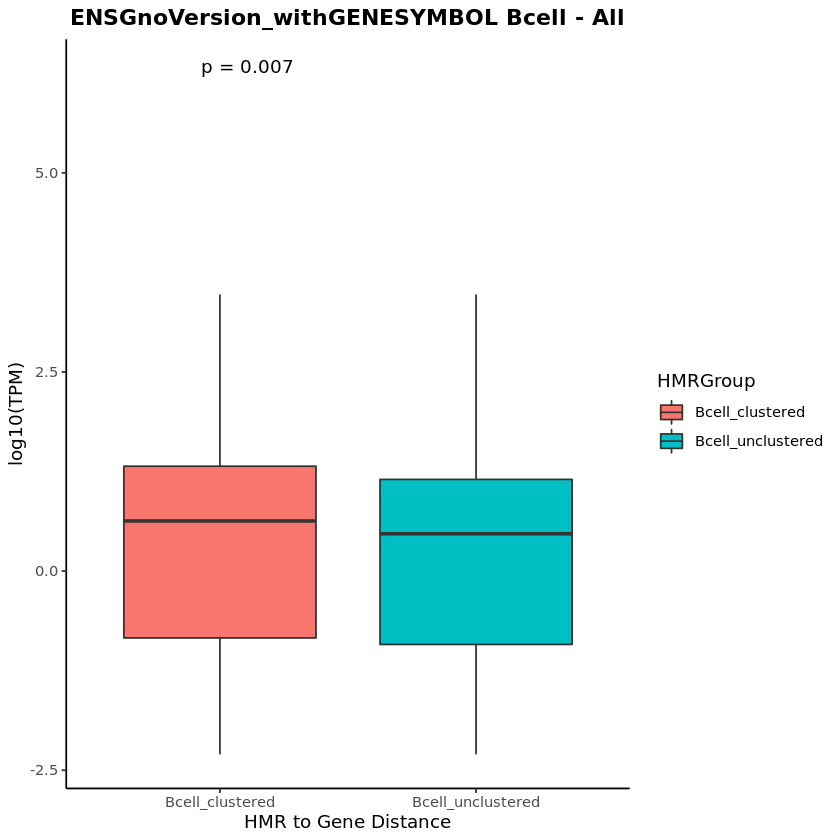

In [13]:
ggplot(Bcell_clustersContainsCS_Unclustered.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin, aes(x=HMRGroup, y=log10(TPM))) +
  geom_boxplot(aes(fill=HMRGroup)) +
  theme_classic() +
  ggtitle("ENSGnoVersion_withGENESYMBOL Bcell - All") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  xlab("HMR to Gene Distance") +
  ylab("log10(TPM)") +
  stat_compare_means(aes(group=HMRGroup), 
                     method="wilcox.test",  
                     method.args = list(alternative = "two.sided"),
                     label="p",
                     label.y=6.25)

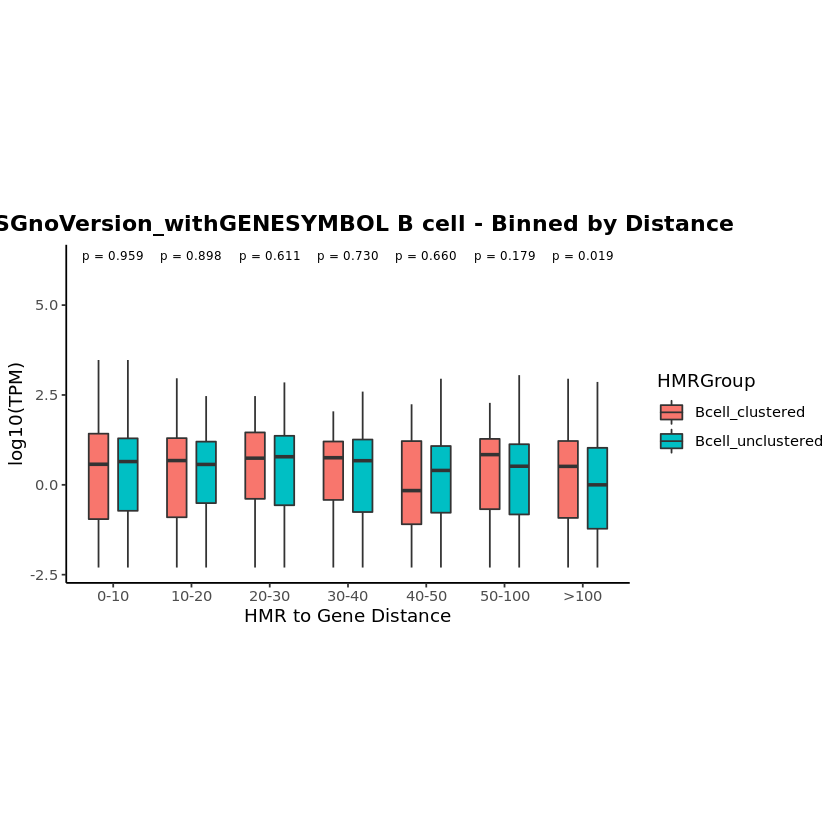

In [19]:
ggplot(Bcell_clustersContainsCS_Unclustered.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin, aes(x=distBin, y=log10(TPM))) +
  geom_boxplot(aes(fill=HMRGroup), width = .5, position=position_dodge(.75)) +
  theme_classic() +
  ggtitle("ENSGnoVersion_withGENESYMBOL B cell - Binned by Distance") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  xlab("HMR to Gene Distance") +
  ylab("log10(TPM)") +
  stat_compare_means(aes(group=HMRGroup), 
                     method="wilcox.test",  
                     method.args = list(alternative = "two.sided"),
                     label="p",
                     label.y=6.25,
                    size = 2.5) +
  theme(aspect.ratio = .6)

# Plot fraction HMRs

In [23]:
Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered

ChrHMRTSS,StartHMRTSS,EndHMRTSS,ChrHMR,StartHMR,EndHMR,HMRGroup,ChrTSS,StartTSS,EndTSS,TPM,strand,GENE_SYMBOL,ENSEMBL,HMRTSSDist
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,993725,1009688,chr1,993725,1006171,Bcell_ClusteredCS,chr1,1009687,1009688,0.005,-1,RNF223,ENSG00000237330,3517
chr1,955503,1006171,chr1,993725,1006171,Bcell_ClusteredCS,chr1,955503,955504,15.745,1,AGRN,ENSG00000188157,38222
chr1,1092645,1109265,chr1,1092645,1106080,Bcell_ClusteredCS,chr1,1109264,1109265,0.020,1,TTLL10,ENSG00000162571,3185
chr1,1092645,1142072,chr1,1092645,1106080,Bcell_ClusteredCS,chr1,1142071,1142072,2.365,-1,TNFRSF18,ENSG00000186891,35992
chr1,1771819,1822496,chr1,1771819,1779732,Bcell_ClusteredCS,chr1,1822495,1822496,126.210,-1,GNB1,ENSG00000078369,42764
chr1,1711896,1779732,chr1,1771819,1779732,Bcell_ClusteredCS,chr1,1711896,1711897,32.945,-1,NADK,ENSG00000008130,59923
chr1,1822495,1841244,chr1,1827360,1841244,Bcell_ClusteredCS,chr1,1822495,1822496,126.210,-1,GNB1,ENSG00000078369,4865
chr1,1827360,1846267,chr1,1827360,1841244,Bcell_ClusteredCS,chr1,1846266,1846267,0.045,1,CALML6,ENSG00000169885,5023
chr1,3513491,3528060,chr1,3513491,3516570,Bcell_ClusteredCS,chr1,3528059,3528060,0.140,-1,MEGF6,ENSG00000162591,11490


In [26]:
Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% group_by(ChrHMR, StartHMR, EndHMR) %>% top_n(n = 1, wt = -HMRTSSDist) %>% nrow()

[1] 412

In [16]:
Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM

ENSEMBL,TPM,HMRTSSDist,HMRGroup
<chr>,<dbl>,<dbl>,<chr>
ENSG00000002822,21.650,304807,Bcell_clustered
ENSG00000004848,0.005,9410,Bcell_clustered
ENSG00000006116,0.010,234975,Bcell_clustered
ENSG00000006459,0.460,46006,Bcell_clustered
ENSG00000007129,5.185,14212,Bcell_clustered
ENSG00000007237,21.120,145854,Bcell_clustered
ENSG00000007312,41.215,3906,Bcell_clustered
ENSG00000007923,19.370,260017,Bcell_clustered
ENSG00000008130,32.945,59923,Bcell_clustered


In [15]:
Bcell_clustersContainsCS_Unclustered.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin

ENSEMBL,TPM,HMRTSSDist,HMRGroup,distBin
<chr>,<dbl>,<dbl>,<chr>,<fct>
ENSG00000002822,21.650,304807,Bcell_clustered,>100
ENSG00000004848,0.005,9410,Bcell_clustered,0-10
ENSG00000006116,0.010,234975,Bcell_clustered,>100
ENSG00000006459,0.460,46006,Bcell_clustered,40-50
ENSG00000007129,5.185,14212,Bcell_clustered,10-20
ENSG00000007237,21.120,145854,Bcell_clustered,>100
ENSG00000007312,41.215,3906,Bcell_clustered,0-10
ENSG00000007923,19.370,260017,Bcell_clustered,>100
ENSG00000008130,32.945,59923,Bcell_clustered,50-100


In [14]:
threshold_list <- c(10000,25000,50000,75000,100000,150000)

numGene_CLcontainsCS <- tibble(
    thresholds = threshold_list,
    HMRGroup = "Bcell_clustersContainsCS"
)

numGene_UNCS <- tibble(
    thresholds = threshold_list,
    HMRGroup = "Bcell_unclustered"
)


get_numGenes_per_threshold <- function(thresh, df){
    df %>% filter(HMRTSSDist < thresh) %>% group_by(nrow()
}

In [30]:
# Get numbers by threshold

# CLusters that contain Cell Specific 
CLcontainsCS_counts <- map(threshold_list, get_numGenes_per_threshold, df = Bcell_clusters_containsCS.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM)

numGene_CLcontainsCS$HMRCounts <- unlist(CLcontainsCS_counts)

# UNclustered Cell specific 
UNCS_counts <- map(threshold_list, get_numGenes_per_threshold, df = Bcell_unclustered_cellspecific.2NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM)

numGene_UNCS$HMRCounts <- unlist(UNCS_counts)

In [33]:
numGene_CLcontainsCS_fraction <- numGene_CLcontainsCS %>% mutate(fraction = (HMRCounts/484) )
numGene_UNCS_fraction <- numGene_UNCS %>% mutate(fraction = (HMRCounts/1844) )

numGene_CLcontainsCS_UNCS_fraction <- rbind(numGene_CLcontainsCS_fraction, numGene_UNCS_fraction)

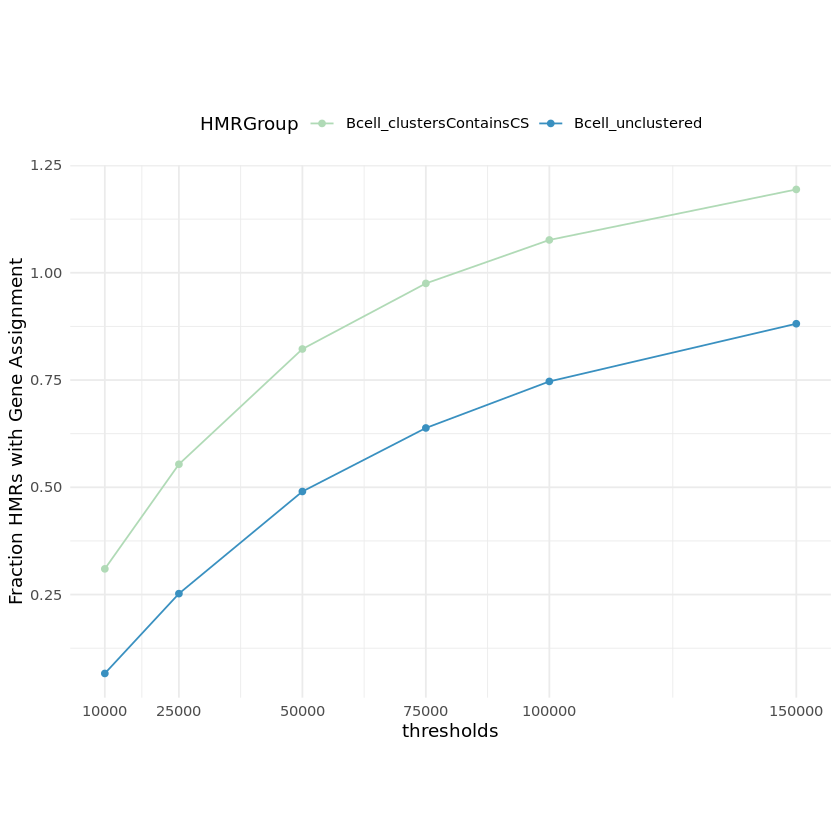

In [35]:
p_numGene <- numGene_CLcontainsCS_UNCS_fraction %>%
ggplot(aes(x = thresholds, y = fraction, color = HMRGroup)) +
geom_point() + 
geom_line() +
theme_minimal() +
scale_color_manual(values=c("#B0DAB6", "#3990C0")) +
theme(aspect.ratio = .7, legend.position = "top") +
scale_x_continuous(breaks=threshold_list) +
ylab("Fraction HMRs with Gene Assignment")
p_numGene

## Fraction ratio

In [36]:
numGene_CLcontainsCS_UNCS_fractionRatio <- merge(numGene_CLcontainsCS_fraction, numGene_UNCS_fraction, by = "thresholds") %>% mutate(fractionRatio = (fraction.x/fraction.y))

In [37]:
numGene_CLcontainsCS_UNCS_fractionRatio

thresholds,HMRGroup.x,HMRCounts.x,fraction.x,HMRGroup.y,HMRCounts.y,fraction.y,fractionRatio
<dbl>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
10000,Bcell_clustersContainsCS,150,0.3099174,Bcell_unclustered,122,0.06616052,4.684325
25000,Bcell_clustersContainsCS,268,0.5537190,Bcell_unclustered,465,0.25216920,2.195823
50000,Bcell_clustersContainsCS,398,0.8223140,Bcell_unclustered,904,0.49023861,1.677375
75000,Bcell_clustersContainsCS,472,0.9752066,Bcell_unclustered,1177,0.63828633,1.527851
100000,Bcell_clustersContainsCS,521,1.0764463,Bcell_unclustered,1377,0.74674620,1.441516
150000,Bcell_clustersContainsCS,578,1.1942149,Bcell_unclustered,1625,0.88123644,1.355158


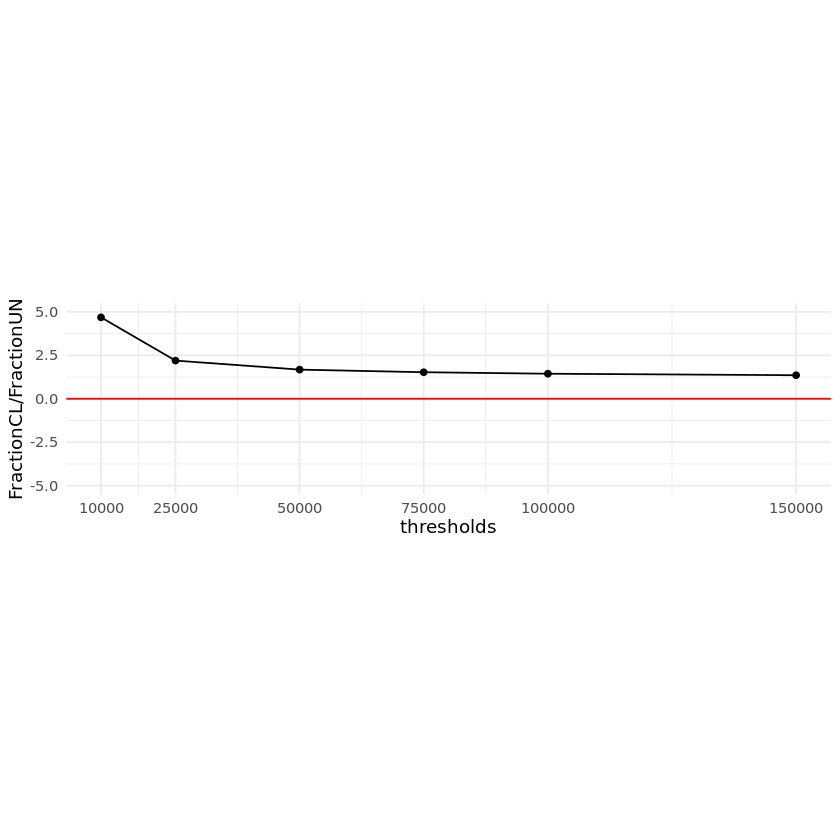

In [39]:
p_numGeneFraction <- numGene_CLcontainsCS_UNCS_fractionRatio %>% 
ggplot(aes(x = thresholds, y = fractionRatio)) +
geom_point() + 
geom_line() +
geom_hline(yintercept = 0, color = "red") + 
coord_cartesian(ylim = c(-5,5)) +
theme_minimal() +
scale_x_continuous(breaks=threshold_list) + 
theme(aspect.ratio = .25) +
ylab("FractionCL/FractionUN")

p_numGeneFraction

## Plot together

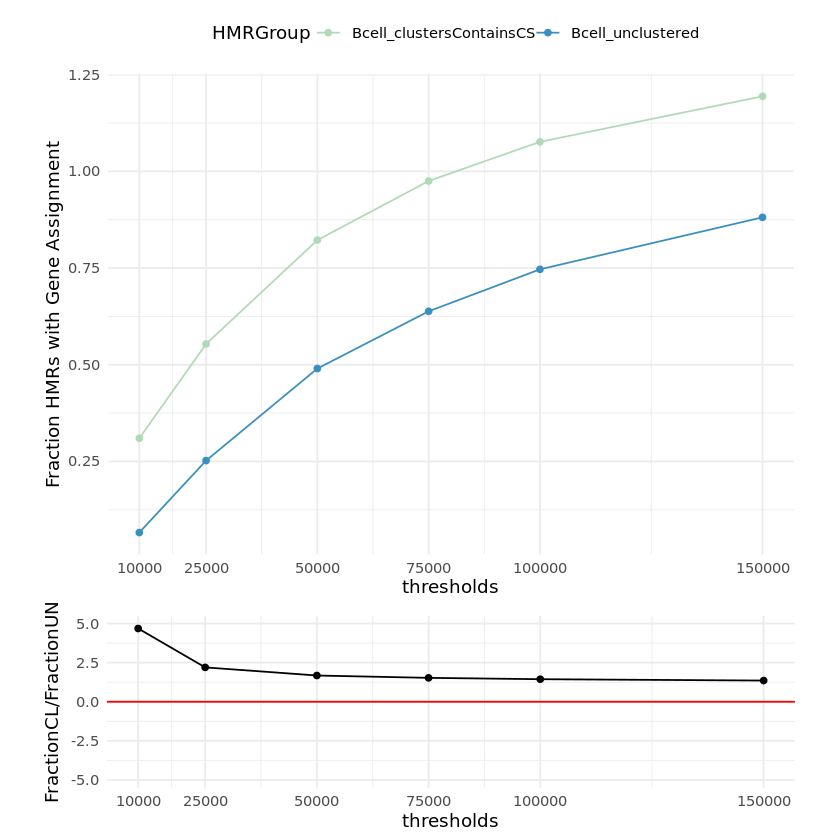

In [40]:
ggpubr::ggarrange(p_numGene, p_numGeneFraction, nrow = 2, align = "v", heights = c(4, 1.539))

# Plot fraction HMRs - 1 NN

## Find 100NN

In [1]:
HOME_DIR=/data/hodges_lab/Tim/nnRNA_TPM_EHGM/
mkdir -p ${HOME_DIR}
REF_DIR=${HOME_DIR}reference_files/

# Directory 
mkdir -p ${HOME_DIR}intermediate_files
cd ${HOME_DIR}intermediate_files

INTER_DIR=${HOME_DIR}intermediate_files/
REF_DIR=${HOME_DIR}reference_files/
OUT_DIR=${HOME_DIR}output_files/

echo "Done."

ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected '/'
1: HOME_DIR=/
             ^


In [ ]:
# Bcell 
bedtools sort -i ${REF_DIR}GM_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.txt | awk 'BEGIN{OFS=FS="\t"}{print }' - > ${REF_DIR}GM_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.sorted.txt

echo "Done."

In [ ]:
# Initalize HMR files 
CLUSTERED_CS_FILE=/data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_internalClusters_individualHMRs_cellspecific_hpl.txt
UNCLUSTERED_CS_FILE=/data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_unclustered_cellspecific_hpl.txt

awk 'BEGIN{OFS=FS="\t"}{print $1,$2,$3,"Bcell_ClusteredCS"}' ${CLUSTERED_CS_FILE} | bedtools sort -i - > ${INTER_DIR}Bcell.clustered_cs.tmp_sorted.txt
awk 'BEGIN{OFS=FS="\t"}{print $1,$2,$3,"Bcell_UnclusteredCS"}' ${UNCLUSTERED_CS_FILE} | bedtools sort -i - > ${INTER_DIR}Bcell.unclustered_cs.tmp_sorted.txt

echo "Done."

## How many clusters are represented by the individual clustered cell specific HMRs
bedtools intersect -u -a /data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_internalClusters_hpl.txt -b /data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_internalClusters_individualHMRs_cellspecific_hpl.txt > ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.txt

wc -l ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.txt

awk 'BEGIN{OFS=FS="\t"}{print $1,$2,$3,"Bcell_ClusteredCS"}' ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.txt | bedtools sort -i - > ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.tmp_sorted.txt

echo "Done."

In [4]:
bedtools closest -d -k 100 -a ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.tmp_sorted.txt -b ${REF_DIR}GM_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.sorted.txt > ${INTER_DIR}Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.txt

echo "Done."

Done.


In [5]:
bedtools closest -d -k 100 -a ${INTER_DIR}Bcell.unclustered_cs.tmp_sorted.txt -b ${REF_DIR}GM_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.sorted.txt > ${INTER_DIR}Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.txt

echo "Done."

Done.


## TAD Filter

In [6]:
# Intersect 2NN file with TADs

# First, create an HMR-Gene end-to-end BED file:
#"ChrHMRProm","StartHMRProm","EndHMRProm","ChrHMR","StartHMR","EndHMR","ChrProm","StartProm","EndProm","ENSEMBL","TPM","HMRPromDist","HMRGroup"

# Check if HMR is before the TSS, else, TSS before  
awk 'BEGIN{OFS=FS="\t"}{if ($2<$6)
print $1,$2,$7,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
else print $1,$6,$3,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
}' ${INTER_DIR}Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.txt | awk 'BEGIN{OFS=FS="\t"}{if ($2!~/-1/) print}' - > ${INTER_DIR}Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt 

awk 'BEGIN{OFS=FS="\t"}{if ($2<$6)
print $1,$2,$7,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
else print $1,$6,$3,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
}' ${INTER_DIR}Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.txt | awk 'BEGIN{OFS=FS="\t"}{if ($2!~/-1/) print}' - > ${INTER_DIR}Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt

echo "Made continuous BED file."


Made continuous BED file.


In [7]:
bedtools intersect -f 1.0 -a ${INTER_DIR}Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt \
-b ${REF_DIR}GM12878_Lieberman-raw_TADs.txt > ${INTER_DIR}Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt

bedtools intersect -f 1.0 -a ${INTER_DIR}Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt  \
-b ${REF_DIR}GM12878_Lieberman-raw_TADs.txt > ${INTER_DIR}Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt

echo "Done."

Done.


## Filter down to 1NN per HMR

In [5]:
library(tidyverse)
library(ggplot2)
library(ggpubr)

#Set working directory 
setwd("/data/hodges_lab/Tim/nnRNA_TPM_EHGM/output_files/")

print("Loaded libraries.")

[1] "Loaded libraries."


In [6]:
Bcell_clusters_containsCS <- read_tsv("/data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Bcell_internalClusters_hpl.containsCellSpecificHMR.txt", col_names = c("chr","start","end","numHMRs"))

Bcell_unclustered_CS <- 
read_tsv("/data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_unclustered_cellspecific_hpl.txt",  col_names = c("chr","start","end"))

Rows: 484 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chr
dbl (3): start, end, numHMRs

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1844 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chr
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
Bcell_clusters_containsCS %>% filter(chr!="chrY") %>% nrow()

[1] 444

In [16]:
Bcell_unclustered_CS %>% filter(chr!="chrY") %>% nrow()

[1] 1621

In [7]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered <- read_tsv("../intermediate_files/Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt", col_names=F) %>% magrittr::set_colnames(c("ChrHMRTSS","StartHMRTSS","EndHMRTSS","ChrHMR","StartHMR","EndHMR","HMRGroup","ChrTSS","StartTSS","EndTSS","TPM","strand","GENE_SYMBOL","ENSEMBL","HMRTSSDist")) 


Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered <- read_tsv("../intermediate_files/Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt", col_names=F) %>% magrittr::set_colnames(c("ChrHMRTSS","StartHMRTSS","EndHMRTSS","ChrHMR","StartHMR","EndHMR","HMRGroup","ChrTSS","StartTSS","EndTSS","TPM","strand","GENE_SYMBOL","ENSEMBL","HMRTSSDist"))

Rows: 4210 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): X1, X4, X7, X8, X13, X14
dbl (9): X2, X3, X5, X6, X9, X10, X11, X12, X15

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 11105 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): X1, X4, X7, X8, X13, X14
dbl (9): X2, X3, X5, X6, X9, X10, X11, X12, X15

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
#### Proportion of Clusters(w/ CS) (out of 444 - no chrY) - TAD FILTER

In [8]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% 
group_by(ChrHMR, StartHMR) %>% # Group by each HMR
top_n(n = 1, wt = -HMRTSSDist) %>%  # Take top row by lowest Distance
top_n(n = 1, wt = TPM) %>%  # Might overlap two genes or have a tie in dist. Take top TPM
top_n(n = 1, wt = GENE_SYMBOL) %>%  # Might still overlap two genes with same TPM (often 0TPM), so take first alphabetically
nrow()

[1] 424

In [ ]:
#### Proportion of Clusters(w/ CS) (out of 444 - no chrY) -  TAD FILTER

In [9]:
Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>%
group_by(ChrHMR, StartHMR) %>% # Group by each HMR
top_n(n = 1, wt = -HMRTSSDist) %>%  # Take top row by lowest Distance
top_n(n = 1, wt = TPM) %>%  # Might overlap two genes or have a tie in dist. Take top TPM
top_n(n = 1, wt = GENE_SYMBOL) %>%  # Might still overlap two genes with same TPM (often 0TPM), so take first alphabetically
nrow()

[1] 1480

In [4]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% nrow()

[1] 4210

In [58]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% group_by(ChrHMR, StartHMR) %>% top_n(n = 1, wt = -HMRTSSDist) %>% nrow()

[1] 426

In [30]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% group_by(ChrHMR, StartHMR) %>% top_n(n = 1, wt = -HMRTSSDist) %>% top_n(n = 1, wt = TPM) %>% top_n(n = 1, wt = GENE_SYMBOL) %>% nrow()

[1] 424

In [5]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% group_by(ChrHMR, StartHMR) %>% top_n(n = 1, wt = -HMRTSSDist) %>% top_n(n = 1, wt = TPM) %>% top_n(n = 1, wt = GENE_SYMBOL) %>% nrow()

[1] 426

In [9]:
Bcell_clusters_containsCS %>% filter(chr!="chrY") %>% nrow()
Bcell_clusters_containsCS_noY <- Bcell_clusters_containsCS %>% filter(chr!="chrY")
Bcell_clusters_containsCS_noY %>% nrow()

[1] 444

[1] 444

### Why are not all HMRs represented here?

In [15]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered_eachHMR <-Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% group_by(ChrHMR, StartHMR) %>% top_n(n = 1, wt = -HMRTSSDist)

In [16]:
head(Bcell_clusters_containsCS_noY, 3)
head(Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered_eachHMR, 3)

chr,start,end,numHMRs
<chr>,<dbl>,<dbl>,<dbl>
chr1,993725,1006171,6
chr1,1092645,1106080,5
chr1,1771819,1779732,3


ChrHMRTSS,StartHMRTSS,EndHMRTSS,ChrHMR,StartHMR,EndHMR,HMRGroup,ChrTSS,StartTSS,EndTSS,TPM,strand,GENE_SYMBOL,ENSEMBL,HMRTSSDist
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,993725,1009688,chr1,993725,1006171,Bcell_ClusteredCS,chr1,1009687,1009688,0.005,-1,RNF223,ENSG00000237330,3517
chr1,1092645,1109265,chr1,1092645,1106080,Bcell_ClusteredCS,chr1,1109264,1109265,0.020,1,TTLL10,ENSG00000162571,3185
chr1,1771819,1822496,chr1,1771819,1779732,Bcell_ClusteredCS,chr1,1822495,1822496,126.210,-1,GNB1,ENSG00000078369,42764


In [ ]:
### I just want to figure out what HMRs aren't represented in this list 

In [37]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered_eachHMR_ChrStrEnd <- Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered_eachHMR %>% ungroup %>% mutate(ChrStrEnd = paste0(ChrHMR, StartHMR, EndHMR))

In [32]:
# Check for HMRs from 444 file that aren't in the 426
Bcell_clusters_containsCS_noY_ChrStrEnd <- Bcell_clusters_containsCS_noY %>% mutate(ChrStrEnd = paste0(chr, start, end))


head(Bcell_clusters_containsCS_noY_ChrStrEnd, 3)

chr,start,end,numHMRs,ChrStrEnd
<chr>,<dbl>,<dbl>,<dbl>,<chr>
chr1,993725,1006171,6,chr19937251006171
chr1,1092645,1106080,5,chr110926451106080
chr1,1771819,1779732,3,chr117718191779732


In [39]:
nrow(Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered_eachHMR_ChrStrEnd)
nrow(Bcell_clusters_containsCS_noY_ChrStrEnd)

[1] 426

[1] 444

In [46]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered_eachHMR

ChrHMRTSS,StartHMRTSS,EndHMRTSS,ChrHMR,StartHMR,EndHMR,HMRGroup,ChrTSS,StartTSS,EndTSS,TPM,strand,GENE_SYMBOL,ENSEMBL,HMRTSSDist
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,993725,1009688,chr1,993725,1006171,Bcell_ClusteredCS,chr1,1009687,1009688,0.005,-1,RNF223,ENSG00000237330,3517
chr1,1092645,1109265,chr1,1092645,1106080,Bcell_ClusteredCS,chr1,1109264,1109265,0.020,1,TTLL10,ENSG00000162571,3185
chr1,1771819,1822496,chr1,1771819,1779732,Bcell_ClusteredCS,chr1,1822495,1822496,126.210,-1,GNB1,ENSG00000078369,42764
chr1,1822495,1841244,chr1,1827360,1841244,Bcell_ClusteredCS,chr1,1822495,1822496,126.210,-1,GNB1,ENSG00000078369,4865
chr1,3513491,3528060,chr1,3513491,3516570,Bcell_ClusteredCS,chr1,3528059,3528060,0.140,-1,MEGF6,ENSG00000162591,11490
chr1,3569325,3595883,chr1,3582641,3595883,Bcell_ClusteredCS,chr1,3569325,3569326,15.720,-1,WRAP73,ENSG00000116213,13316
chr1,3634649,3663901,chr1,3634649,3636909,Bcell_ClusteredCS,chr1,3663900,3663901,4.680,-1,TP73-AS1,ENSG00000227372,26992
chr1,6845384,7029550,chr1,7022001,7029550,Bcell_ClusteredCS,chr1,6845384,6845385,21.875,1,CAMTA1,ENSG00000171735,176617
chr1,9352939,9489443,chr1,9458264,9489443,Bcell_ClusteredCS,chr1,9352939,9352940,0.350,1,SPSB1,ENSG00000171621,105325


In [48]:
any(Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered_eachHMR$GENE_SYMBOL %in% c("AJAP1"))

[1] FALSE

In [45]:
Bcell_clusters_containsCS_noY_ChrStrEnd[!Bcell_clusters_containsCS_noY_ChrStrEnd$ChrStrEnd %in% Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered_eachHMR_ChrStrEnd$ChrStrEnd,]

chr,start,end,numHMRs,ChrStrEnd
<chr>,<dbl>,<dbl>,<dbl>,<chr>
chr1,5563453,5574936,3,chr155634535574936
chr11,47874951,47886929,4,chr114787495147886929
chr11,130270630,130272416,3,chr11130270630130272416
chr12,3151454,3159745,3,chr1231514543159745
chr14,105997956,106004559,3,chr14105997956106004559
chr14,106023653,106058328,11,chr14106023653106058328
chr15,42219962,42227869,3,chr154221996242227869
chr15,74665831,74679743,6,chr157466583174679743
chr15,79043350,79051465,3,chr157904335079051465


### Filter down 

In [16]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.1NN <-Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% 
group_by(ChrHMR, StartHMR) %>% # Group by each HMR
top_n(n = 1, wt = -HMRTSSDist) %>%  # Take top row by lowest Distance
top_n(n = 1, wt = TPM) %>%  # Might overlap two genes or have a tie in dist. Take top TPM
top_n(n = 1, wt = GENE_SYMBOL)  # Might still overlap two genes with same TPM (often 0TPM), so take first alphabetically

Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.1NN <-Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>%
group_by(ChrHMR, StartHMR) %>% # Group by each HMR
top_n(n = 1, wt = -HMRTSSDist) %>%  # Take top row by lowest Distance
top_n(n = 1, wt = TPM) %>%  # Might overlap two genes or have a tie in dist. Take top TPM
top_n(n = 1, wt = GENE_SYMBOL)  # Might still overlap two genes with same TPM (often 0TPM), so take first alphabetically

## Calculate fractions

In [17]:
threshold_list <- c(10000,25000,50000,75000,100000,150000)

numGene_CLcontainsCS_1NN <- tibble(
    thresholds = threshold_list,
    HMRGroup = "Bcell_clustersContainsCS"
)

numGene_UNCS_1NN <- tibble(
    thresholds = threshold_list,
    HMRGroup = "Bcell_unclustered"
)


get_numGenes_per_threshold <- function(thresh, df){
    df %>% dplyr::filter(HMRTSSDist < thresh) %>% nrow()
}
                                                    
print("Initialized.")

[1] "Initialized."


In [18]:
# Get numbers by threshold

# CLusters that contain Cell Specific 
CLcontainsCS_counts <- map(threshold_list, get_numGenes_per_threshold, df = Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.1NN)

numGene_CLcontainsCS_1NN$HMRCounts <- unlist(CLcontainsCS_counts)



# UNclustered Cell specific 
UNCS_counts <- map(threshold_list, get_numGenes_per_threshold, df = Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.1NN)

numGene_UNCS_1NN$HMRCounts <- unlist(UNCS_counts)

print("Done.")

[1] "Done."


In [19]:
# Calc fraction
numGene_CLcontainsCS_1NN_fraction <- numGene_CLcontainsCS_1NN %>% mutate(fraction = (HMRCounts/444) )
numGene_UNCS_1NN_fraction <- numGene_UNCS_1NN %>% mutate(fraction = (HMRCounts/1621) )

numGene_CLcontainsCS_UNCS_1NN_fraction <- rbind(numGene_CLcontainsCS_1NN_fraction, numGene_UNCS_1NN_fraction)

print("Done.")

[1] "Done."


## Plot

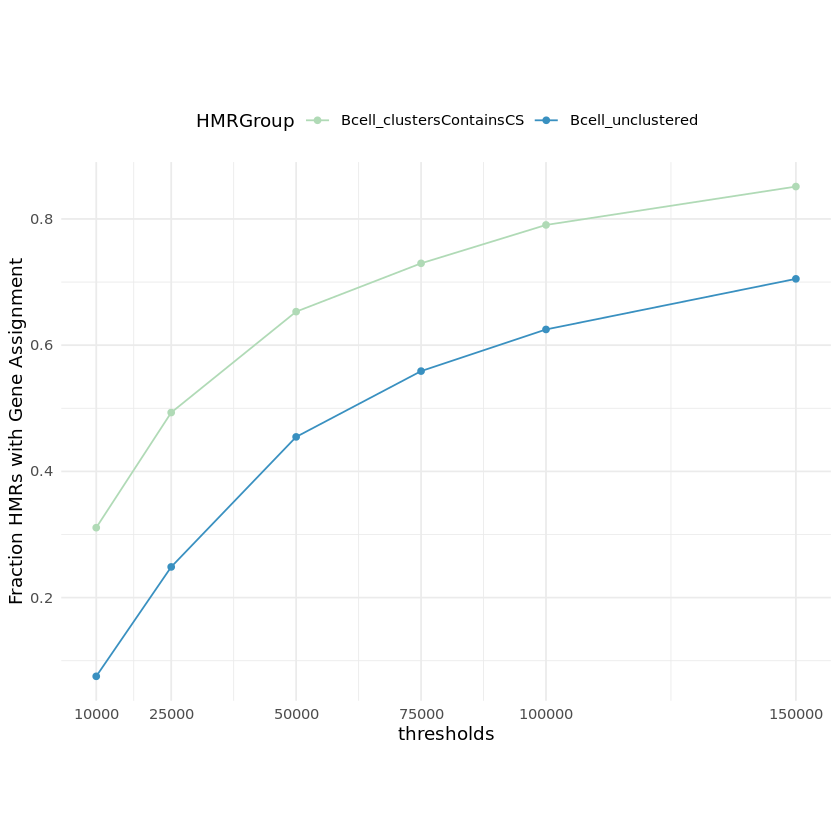

In [20]:
p_numGene_1NN <- numGene_CLcontainsCS_UNCS_1NN_fraction %>%
ggplot(aes(x = thresholds, y = fraction)) +
geom_point(aes(color = HMRGroup)) + 
geom_line(aes(color = HMRGroup)) +
theme_minimal() +
scale_color_manual(values=c("#B0DAB6", "#3990C0")) +
theme(aspect.ratio = .7, legend.position = "top") +
scale_x_continuous(breaks=threshold_list) +
ylab("Fraction HMRs with Gene Assignment")
p_numGene_1NN

In [ ]:
## Fraction of fractions

In [21]:
numGene_CLcontainsCS_UNCS_1NN_fractionRatio <- merge(numGene_CLcontainsCS_1NN_fraction, numGene_UNCS_1NN_fraction, by = "thresholds") %>% mutate(fractionRatio = (fraction.x/fraction.y))

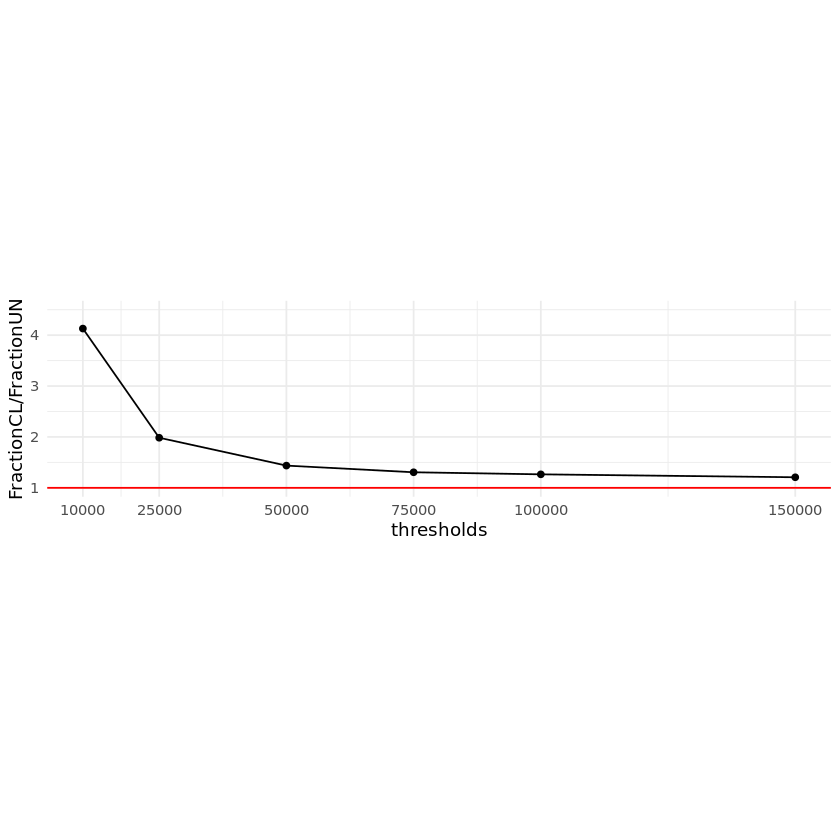

In [22]:
p_numGeneFraction_1NN <- numGene_CLcontainsCS_UNCS_1NN_fractionRatio %>% 
ggplot(aes(x = thresholds, y = fractionRatio)) +
geom_point() + 
geom_line() +
geom_hline(yintercept = 1, color = "red") + 
coord_cartesian(ylim = c(1,4.5)) +
theme_minimal() +
scale_x_continuous(breaks=threshold_list) + 
theme(aspect.ratio = .25) +
ylab("FractionCL/FractionUN")

p_numGeneFraction_1NN

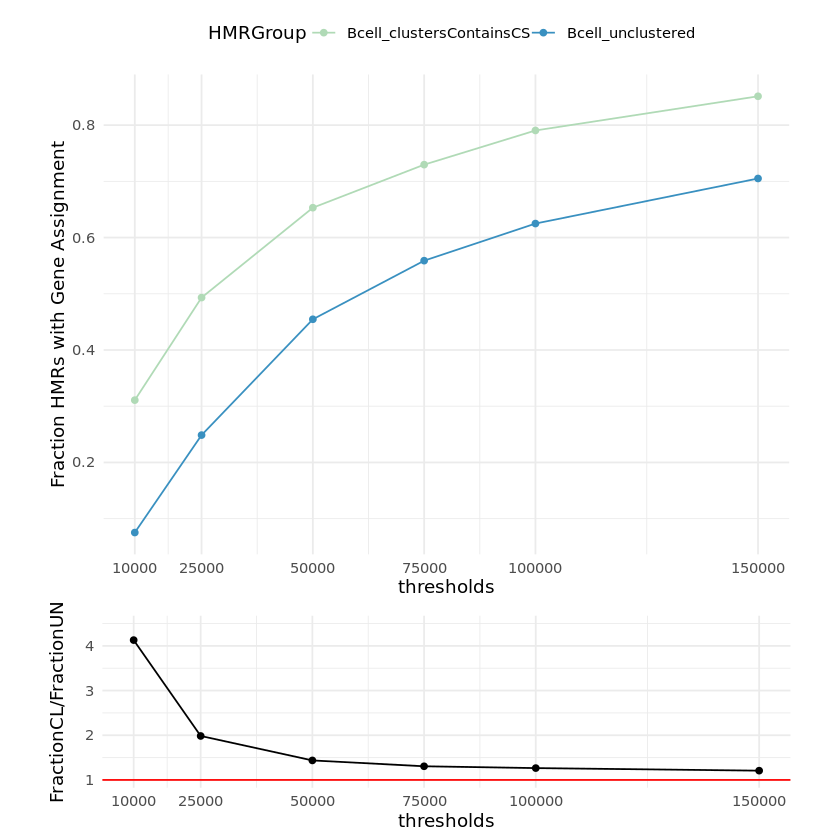

In [23]:
ggpubr::ggarrange(p_numGene_1NN, p_numGeneFraction_1NN, nrow = 2, align = "v", heights = c(4, 1.539))

## Stats for fractions

In [24]:
head(numGene_CLcontainsCS_UNCS_1NN_fractionRatio, 3)

,thresholds,HMRGroup.x,HMRCounts.x,fraction.x,HMRGroup.y,HMRCounts.y,fraction.y,fractionRatio
,<dbl>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
1,10000,Bcell_clustersContainsCS,138,0.3108108,Bcell_unclustered,122,0.07526218,4.129708
2,25000,Bcell_clustersContainsCS,219,0.4932432,Bcell_unclustered,403,0.24861197,1.983988
3,50000,Bcell_clustersContainsCS,290,0.6531532,Bcell_unclustered,737,0.45465762,1.436582


In [31]:
numGene_CLcontainsCS_UNCS_1NN_fractionRatio_pvals <- numGene_CLcontainsCS_UNCS_1NN_fractionRatio %>% rowwise() %>% mutate(
    propTestP = prop.test(x = c(HMRCounts.x, HMRCounts.y), n = c(444, 1621))$p.value,
    propTestStat = prop.test(x = c(HMRCounts.x, HMRCounts.y), n = c(444, 1621))$statistic,
)
numGene_CLcontainsCS_UNCS_1NN_fractionRatio_pvals

thresholds,HMRGroup.x,HMRCounts.x,fraction.x,HMRGroup.y,HMRCounts.y,fraction.y,fractionRatio,propTestP,propTestStat
<dbl>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
10000,Bcell_clustersContainsCS,138,0.3108108,Bcell_unclustered,122,0.07526218,4.129708,1.224932e-39,173.57631
25000,Bcell_clustersContainsCS,219,0.4932432,Bcell_unclustered,403,0.24861197,1.983988,4.320121e-23,97.93652
50000,Bcell_clustersContainsCS,290,0.6531532,Bcell_unclustered,737,0.45465762,1.436582,1.866878e-13,54.14015
75000,Bcell_clustersContainsCS,324,0.7297297,Bcell_unclustered,906,0.55891425,1.305620,1.168654e-10,41.51675
100000,Bcell_clustersContainsCS,351,0.7905405,Bcell_unclustered,1013,0.62492289,1.265021,9.607968e-11,41.89965
150000,Bcell_clustersContainsCS,378,0.8513514,Bcell_unclustered,1143,0.70512030,1.207385,8.423779e-10,37.65945


png 
  2

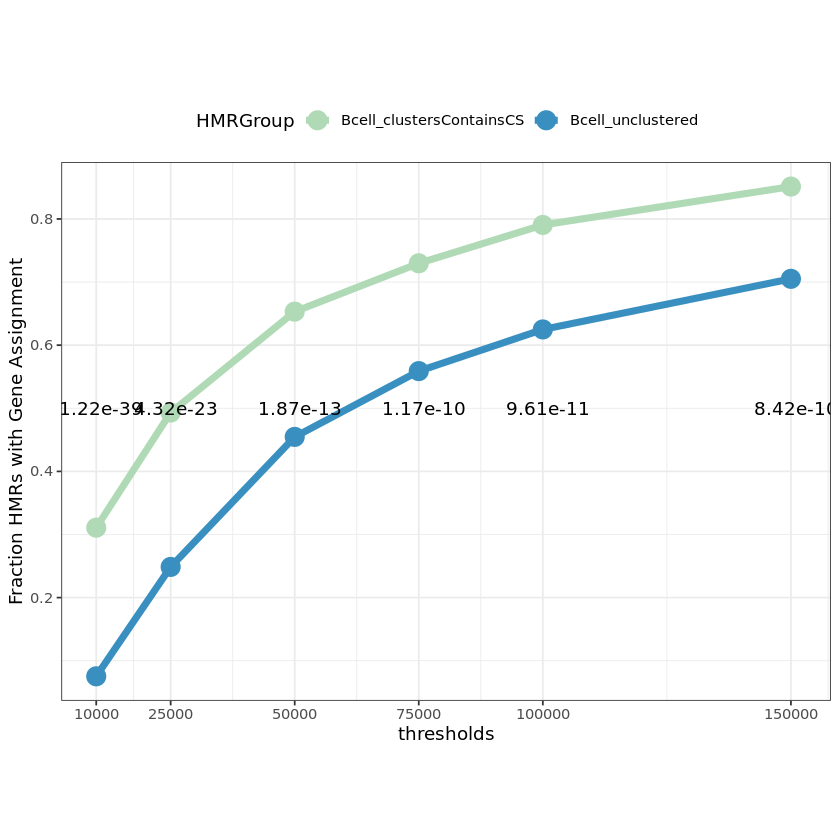

In [30]:
pdf("Bcell.TAD.1NN.UniqueGenes.ProportionOfHMRsbyDistance.June11.pdf")

p_numGene_1NN_stats <- numGene_CLcontainsCS_UNCS_1NN_fraction %>%
ggplot(aes(x = thresholds, y = fraction)) +
geom_point(aes(color = HMRGroup), size = 5) + 
geom_line(aes(color = HMRGroup), size = 2) +
theme_bw() +
scale_color_manual(values=c("#B0DAB6", "#3990C0")) +
theme(aspect.ratio = .7, legend.position = "top") +
scale_x_continuous(breaks=threshold_list) +
ylab("Fraction HMRs with Gene Assignment") +
geom_text(data = numGene_CLcontainsCS_UNCS_1NN_fractionRatio_pvals, aes(x = thresholds+1000, y = .5, label = format(propTestP, digits=3)))
p_numGene_1NN_stats

dev.off()
p_numGene_1NN_stats

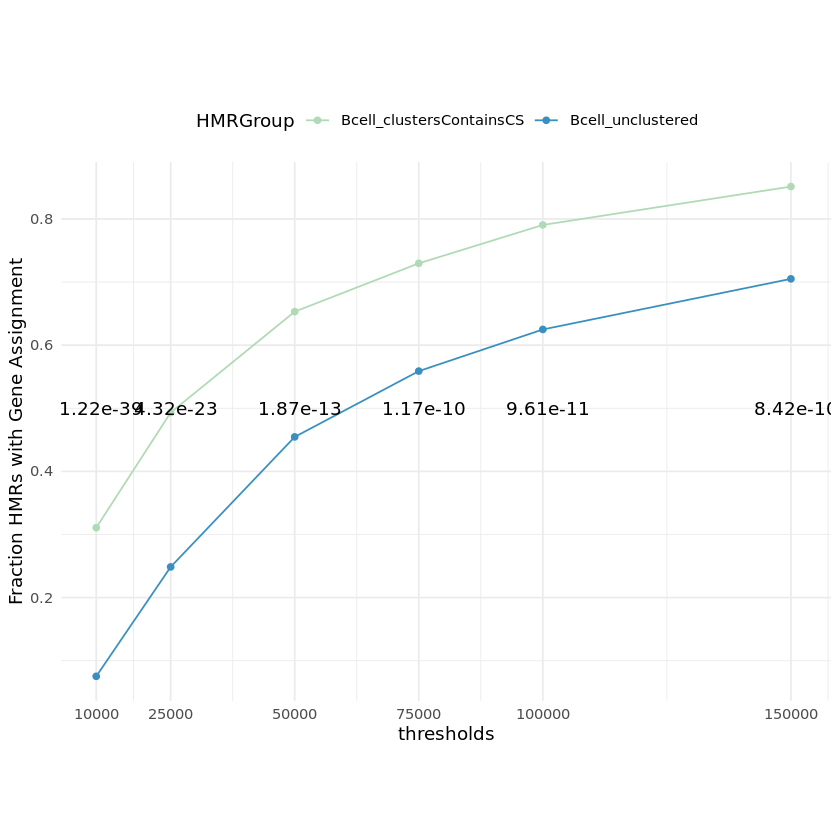

In [28]:
p_numGene_1NN_stats <- p_numGene_1NN +
geom_text(data = numGene_CLcontainsCS_UNCS_1NN_fractionRatio_pvals, aes(x = thresholds+1000, y = .5, label = format(propTestP, digits=3)))
p_numGene_1NN_stats

In [29]:
pdf("Bcell.TAD.1NN.UniqueGenes.ProportionOfHMRsbyDistance.June11.pdf")

p_numGene_1NN_stats

dev.off()

png 
  2

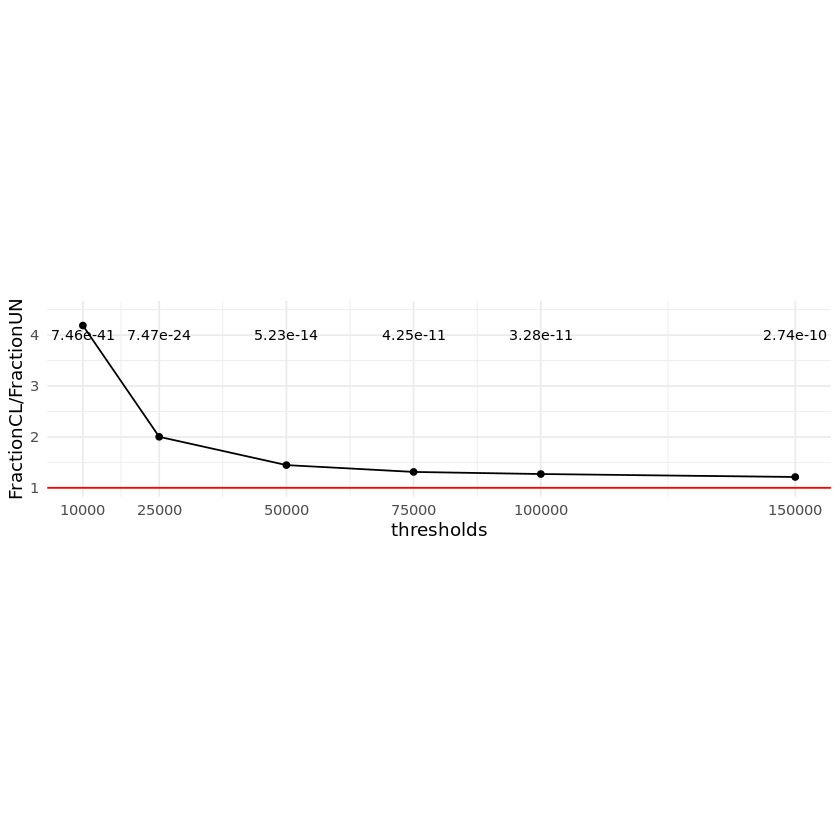

In [73]:
p_numGeneFraction_1NN +
geom_text(data = numGene_CLcontainsCS_UNCS_1NN_fractionRatio_pvals, aes(x = thresholds, y = 4, label = format(propTestP, digits=3)), size = 3)

In [ ]:
## Plot w/ stats

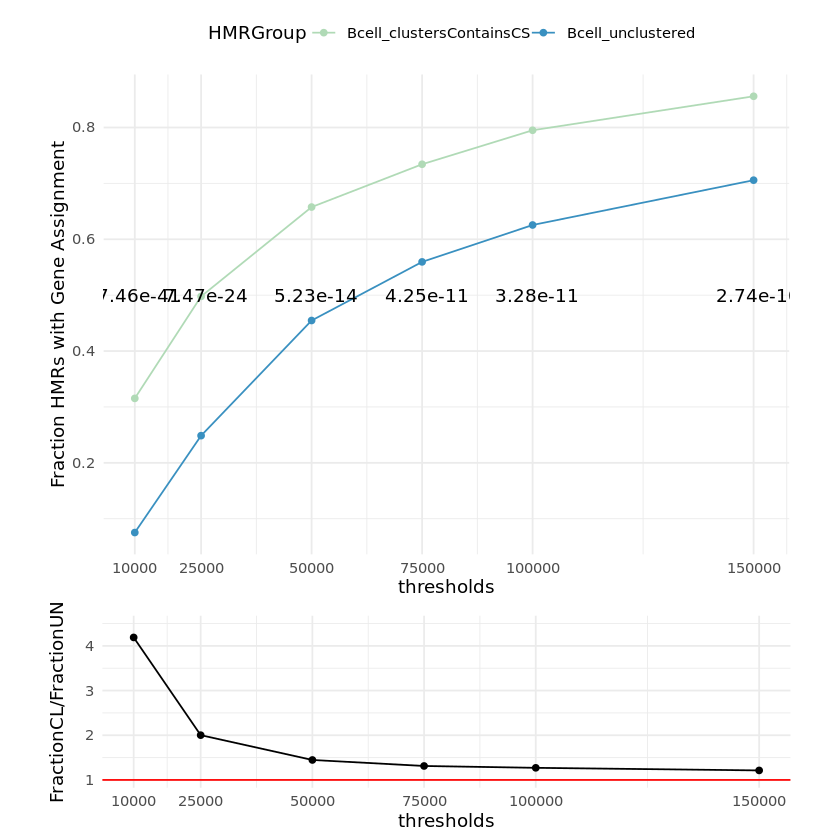

In [16]:
ggpubr::ggarrange(p_numGene_1NN_stats, p_numGeneFraction_1NN, nrow = 2, align = "v", heights = c(4, 1.539))

# Plot fraction HMRs - no TPM filter

## Find 100NN

In [1]:
HOME_DIR=/data/hodges_lab/Tim/nnRNA_TPM_EHGM/
mkdir -p ${HOME_DIR}
REF_DIR=${HOME_DIR}reference_files/

# Directory 
mkdir -p ${HOME_DIR}intermediate_files
cd ${HOME_DIR}intermediate_files

INTER_DIR=${HOME_DIR}intermediate_files/
REF_DIR=${HOME_DIR}reference_files/
OUT_DIR=${HOME_DIR}output_files/

echo "Done."

Done.


In [4]:
# Bcell GM_ENSG_TPM_avg12_noVersion_hasHGNC_NoTPMFilter.TSS.txt
bedtools sort -i ${REF_DIR}GM_ENSG_TPM_avg12_noVersion_hasHGNC_NoTPMFilter.TSS.txt | awk 'BEGIN{OFS=FS="\t"}{print }' - > ${REF_DIR}GM_ENSG_TPM_avg12_noVersion_hasHGNC_NoTPMFilter.TSS.sorted.txt

echo "Done."

Done.


In [5]:
# Initalize HMR files 
CLUSTERED_CS_FILE=/data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_internalClusters_individualHMRs_cellspecific_hpl.txt
UNCLUSTERED_CS_FILE=/data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_unclustered_cellspecific_hpl.txt

awk 'BEGIN{OFS=FS="\t"}{print $1,$2,$3,"Bcell_ClusteredCS"}' ${CLUSTERED_CS_FILE} | bedtools sort -i - > ${INTER_DIR}Bcell.clustered_cs.tmp_sorted.txt
awk 'BEGIN{OFS=FS="\t"}{print $1,$2,$3,"Bcell_UnclusteredCS"}' ${UNCLUSTERED_CS_FILE} | bedtools sort -i - > ${INTER_DIR}Bcell.unclustered_cs.tmp_sorted.txt

echo "Done."

## How many clusters are represented by the individual clustered cell specific HMRs
bedtools intersect -u -a /data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_internalClusters_hpl.txt -b /data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_internalClusters_individualHMRs_cellspecific_hpl.txt > ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.txt

wc -l ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.txt

awk 'BEGIN{OFS=FS="\t"}{print $1,$2,$3,"Bcell_ClusteredCS"}' ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.txt | bedtools sort -i - > ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.tmp_sorted.txt

echo "Done."

Done.
484 /data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Bcell_internalClusters_hpl.containsCellSpecificHMR.txt
Done.


In [8]:
bedtools closest -d -k 100 -a ${INTER_DIR}Bcell_internalClusters_hpl.containsCellSpecificHMR.tmp_sorted.txt -b ${REF_DIR}GM_ENSG_TPM_avg12_noVersion_hasHGNC_NoTPMFilter.TSS.sorted.txt > ${INTER_DIR}Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.txt

echo "Done."

Done.


In [9]:
bedtools closest -d -k 100 -a ${INTER_DIR}Bcell.unclustered_cs.tmp_sorted.txt -b ${REF_DIR}GM_ENSG_TPM_avg12_noVersion_hasHGNC_NoTPMFilter.TSS.sorted.txtt > ${INTER_DIR}Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.txt

echo "Done."

Error: Unable to open file /data/hodges_lab/Tim/nnRNA_TPM_EHGM/reference_files/GM_ENSG_TPM_avg12_noVersion_hasHGNC_NoTPMFilter.TSS.sorted.txtt. Exiting.
Done.


## TAD Filter

In [10]:
# Intersect 2NN file with TADs

# First, create an HMR-Gene end-to-end BED file:
#"ChrHMRProm","StartHMRProm","EndHMRProm","ChrHMR","StartHMR","EndHMR","ChrProm","StartProm","EndProm","ENSEMBL","TPM","HMRPromDist","HMRGroup"

# Check if HMR is before the TSS, else, TSS before  
awk 'BEGIN{OFS=FS="\t"}{if ($2<$6)
print $1,$2,$7,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
else print $1,$6,$3,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
}' ${INTER_DIR}Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.txt | awk 'BEGIN{OFS=FS="\t"}{if ($2!~/-1/) print}' - > ${INTER_DIR}Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.ContinuousBEDFormat.txt 

awk 'BEGIN{OFS=FS="\t"}{if ($2<$6)
print $1,$2,$7,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
else print $1,$6,$3,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
}' ${INTER_DIR}Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.txt | awk 'BEGIN{OFS=FS="\t"}{if ($2!~/-1/) print}' - > ${INTER_DIR}Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.ContinuousBEDFormat.txt

echo "Made continuous BED file."


Made continuous BED file.


In [2]:
bedtools intersect -f 1.0 -a ${INTER_DIR}Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.ContinuousBEDFormat.txt \
-b ${REF_DIR}GM12878_Lieberman-raw_TADs.txt > ${INTER_DIR}Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.txt

bedtools intersect -f 1.0 -a ${INTER_DIR}Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.ContinuousBEDFormat.txt  \
-b ${REF_DIR}GM12878_Lieberman-raw_TADs.txt > ${INTER_DIR}Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.txt

echo "Done."

Done.


## Filter down to 1NN per HMR

In [59]:
library(tidyverse)
library(ggplot2)
library(ggpubr)

#Set working directory 
setwd("/data/hodges_lab/Tim/nnRNA_TPM_EHGM/output_files/")

print("Loaded libraries.")

[1] "Loaded libraries."


In [60]:
Bcell_clusters_containsCS <- read_tsv("/data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Bcell_internalClusters_hpl.containsCellSpecificHMR.txt", col_names = c("chr","start","end","numHMRs"))

Bcell_unclustered_CS <- 
read_tsv("/data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Bcell_unclustered_cellspecific_hpl.txt",  col_names = c("chr","start","end"))

Rows: 484 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chr
dbl (3): start, end, numHMRs

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1844 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chr
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
Bcell_clusters_containsCS %>% filter(chr!="chrY") %>% nrow()

[1] 444

In [16]:
Bcell_unclustered_CS %>% filter(chr!="chrY") %>% nrow()

[1] 1621

In [61]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered <- read_tsv("../intermediate_files/Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.txt", col_names=F) %>% magrittr::set_colnames(c("ChrHMRTSS","StartHMRTSS","EndHMRTSS","ChrHMR","StartHMR","EndHMR","HMRGroup","ChrTSS","StartTSS","EndTSS","TPM","strand","GENE_SYMBOL","ENSEMBL","HMRTSSDist")) 


Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered <- read_tsv("../intermediate_files/Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.txt", col_names=F) %>% magrittr::set_colnames(c("ChrHMRTSS","StartHMRTSS","EndHMRTSS","ChrHMR","StartHMR","EndHMR","HMRGroup","ChrTSS","StartTSS","EndTSS","TPM","strand","GENE_SYMBOL","ENSEMBL","HMRTSSDist"))

Rows: 6739 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): X1, X4, X7, X8, X13, X14
dbl (9): X2, X3, X5, X6, X9, X10, X11, X12, X15

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 18862 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): X1, X4, X7, X8, X13, X14
dbl (9): X2, X3, X5, X6, X9, X10, X11, X12, X15

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
#### Proportion of Clusters(w/ CS) (out of 444 - no chrY) - WITH TPM FILTER

In [69]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% 
group_by(ChrHMR, StartHMR) %>% # Group by each HMR
top_n(n = 1, wt = -HMRTSSDist) %>%  # Take top row by lowest Distance
top_n(n = 1, wt = TPM) %>%  # Might overlap two genes or have a tie in dist. Take top TPM
top_n(n = 1, wt = GENE_SYMBOL) %>%  # Might still overlap two genes with same TPM (often 0TPM), so take first alphabetically
nrow()

[1] 424

In [ ]:
#### Proportion of Clusters(w/ CS) (out of 444 - no chrY) - NO TPM FILTER

In [64]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered %>% 
group_by(ChrHMR, StartHMR) %>% # Group by each HMR
top_n(n = 1, wt = -HMRTSSDist) %>%  # Take top row by lowest Distance
top_n(n = 1, wt = TPM) %>%  # Might overlap two genes or have a tie in dist. Take top TPM
top_n(n = 1, wt = GENE_SYMBOL) %>%  # Might still overlap two genes with same TPM (often 0TPM), so take first alphabetically
nrow()

[1] 426

In [ ]:
#### Proportion of Unclustered-CS (out of 1621 - no chrY) - WITH  TPM FILTER

In [71]:
Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% 
group_by(ChrHMR, StartHMR) %>% # Group by each HMR
top_n(n = 1, wt = -HMRTSSDist) %>%  # Take top row by lowest Distance
top_n(n = 1, wt = TPM) %>%  # Might overlap two genes or have a tie in dist. Take top TPM
top_n(n = 1, wt = GENE_SYMBOL) %>%  # Might still overlap two genes with same TPM (often 0TPM), so take first alphabetically
nrow()

[1] 1480

In [ ]:
#### Proportion of Unclustered-CS (out of 1621 - no chrY) - NO TPM FILTER

In [66]:
Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered %>% 
group_by(ChrHMR, StartHMR) %>% # Group by each HMR
top_n(n = 1, wt = -HMRTSSDist) %>%  # Take top row by lowest Distance
top_n(n = 1, wt = TPM) %>%  # Might overlap two genes or have a tie in dist. Take top TPM
top_n(n = 1, wt = GENE_SYMBOL) %>%  # Might still overlap two genes with same TPM (often 0TPM), so take first alphabetically
nrow()

[1] 1507

In [73]:
prop.test(x = c(424, 1480), n = c(444, 1621))


	2-sample test for equality of proportions with continuity correction

data:  c(424, 1480) out of c(444, 1621)
X-squared = 7.954, df = 1, p-value = 0.004798
alternative hypothesis: two.sided
95 percent confidence interval:
 0.01683148 0.06704512
sample estimates:
   prop 1    prop 2 
0.9549550 0.9130167 


In [74]:
prop.test(x = c(426, 1507), n = c(444, 1621))


	2-sample test for equality of proportions with continuity correction

data:  c(426, 1507) out of c(444, 1621)
X-squared = 4.6821, df = 1, p-value = 0.03048
alternative hypothesis: two.sided
95 percent confidence interval:
 0.006182606 0.053390230
sample estimates:
   prop 1    prop 2 
0.9594595 0.9296730 


In [5]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered %>% nrow()

[1] 6739

In [54]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered %>% group_by(ChrHMR, StartHMR) %>% top_n(n = 1, wt = -HMRTSSDist) %>% nrow()

[1] 472

In [9]:
Bcell_clusters_containsCS %>% filter(chr!="chrY") %>% nrow()
Bcell_clusters_containsCS_noY <- Bcell_clusters_containsCS %>% filter(chr!="chrY")
Bcell_clusters_containsCS_noY %>% nrow()

[1] 444

[1] 444

### Filter down 

In [6]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered

ChrHMRTSS,StartHMRTSS,EndHMRTSS,ChrHMR,StartHMR,EndHMR,HMRGroup,ChrTSS,StartTSS,EndTSS,TPM,strand,GENE_SYMBOL,ENSEMBL,HMRTSSDist
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,993725,1009688,chr1,993725,1006171,Bcell_ClusteredCS,chr1,1009687,1009688,0.005,-1,RNF223,ENSG00000237330,3517
chr1,955503,1006171,chr1,993725,1006171,Bcell_ClusteredCS,chr1,955503,955504,15.745,1,AGRN,ENSG00000188157,38222
chr1,948803,1006171,chr1,993725,1006171,Bcell_ClusteredCS,chr1,948803,948804,118.565,1,ISG15,ENSG00000187608,44922
chr1,993725,1051742,chr1,993725,1006171,Bcell_ClusteredCS,chr1,1051741,1051742,6.545,-1,C1orf159,ENSG00000131591,45571
chr1,935552,1006171,chr1,993725,1006171,Bcell_ClusteredCS,chr1,935552,935553,0.410,-1,HES4,ENSG00000188290,58173
chr1,901877,1006171,chr1,993725,1006171,Bcell_ClusteredCS,chr1,901877,901878,0.130,1,PLEKHN1,ENSG00000187583,91848
chr1,895967,1006171,chr1,993725,1006171,Bcell_ClusteredCS,chr1,895967,895968,11.080,1,KLHL17,ENSG00000187961,97758
chr1,894689,1006171,chr1,993725,1006171,Bcell_ClusteredCS,chr1,894689,894690,47.415,-1,NOC2L,ENSG00000188976,99036
chr1,993725,1109265,chr1,993725,1006171,Bcell_ClusteredCS,chr1,1109264,1109265,0.020,1,TTLL10,ENSG00000162571,103094


In [8]:
Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered

ChrHMRTSS,StartHMRTSS,EndHMRTSS,ChrHMR,StartHMR,EndHMR,HMRGroup,ChrTSS,StartTSS,EndTSS,TPM,strand,GENE_SYMBOL,ENSEMBL,HMRTSSDist
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,1981909,2032210,chr1,2032031,2032210,Bcell_UnclusteredCS,chr1,1981909,1981910,0.575,1,PRKCZ,ENSG00000067606,50122
chr1,1950780,2032210,chr1,2032031,2032210,Bcell_UnclusteredCS,chr1,1950780,1950781,0.000,1,GABRD,ENSG00000187730,81251
chr1,1935276,2032210,chr1,2032031,2032210,Bcell_UnclusteredCS,chr1,1935276,1935277,0.005,-1,C1orf222,ENSG00000142609,96755
chr1,2032031,2144160,chr1,2032031,2032210,Bcell_UnclusteredCS,chr1,2144159,2144160,26.745,-1,C1orf86,ENSG00000162585,111950
chr1,2032031,2160135,chr1,2032031,2032210,Bcell_UnclusteredCS,chr1,2160134,2160135,5.100,1,SKI,ENSG00000157933,127925
chr1,1850712,2032210,chr1,2032031,2032210,Bcell_UnclusteredCS,chr1,1850712,1850713,0.030,-1,TMEM52,ENSG00000178821,181319
chr1,2032031,2323147,chr1,2032031,2032210,Bcell_UnclusteredCS,chr1,2323146,2323147,2.535,-1,MORN1,ENSG00000116151,290937
chr1,2032031,2323268,chr1,2032031,2032210,Bcell_UnclusteredCS,chr1,2323267,2323268,56.320,1,RER1,ENSG00000157916,291058
chr1,2032031,2345237,chr1,2032031,2032210,Bcell_UnclusteredCS,chr1,2345236,2345237,6.350,-1,PEX10,ENSG00000157911,313027


In [34]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.1NN <-Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered %>% group_by(ChrHMR, StartHMR) %>% top_n(n = 1, wt = -HMRTSSDist) %>% top_n(n = 1, wt = TPM) %>% top_n(n = 1, wt = GENE_SYMBOL)

Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.1NN <-Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered %>% group_by(ChrHMR, StartHMR) %>% top_n(n = 1, wt = -HMRTSSDist) %>% top_n(n = 1, wt = TPM) %>% top_n(n = 1, wt = GENE_SYMBOL)

## Calculate fractions

In [75]:
threshold_list <- c(10000,25000,50000,75000,100000,150000)

numGene_CLcontainsCS_NoTPMFilter_1NN <- tibble(
    thresholds = threshold_list,
    HMRGroup = "Bcell_clustersContainsCS"
)

numGene_UNCS_NoTPMFilter_1NN <- tibble(
    thresholds = threshold_list,
    HMRGroup = "Bcell_unclustered"
)


get_numGenes_per_threshold <- function(thresh, df){
    df %>% filter(HMRTSSDist < thresh) %>% nrow()
}
                                                    
print("Initialized.")

[1] "Initialized."


In [76]:
# Get numbers by threshold

# CLusters that contain Cell Specific 
CLcontainsCS_NoTPMFilter_counts <- map(threshold_list, get_numGenes_per_threshold, df = Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.1NN)

numGene_CLcontainsCS_NoTPMFilter_1NN$HMRCounts <- unlist(CLcontainsCS_NoTPMFilter_counts)



# UNclustered Cell specific 
UNCS_NoTPMFilter_counts <- map(threshold_list, get_numGenes_per_threshold, df = Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.1NN)

numGene_UNCS_NoTPMFilter_1NN$HMRCounts <- unlist(UNCS_NoTPMFilter_counts)

print("Done.")

[1] "Done."


In [77]:
# Calc fraction
numGene_CLcontainsCS_NoTPMFilter_1NN_fraction <- numGene_CLcontainsCS_NoTPMFilter_1NN %>% mutate(fraction = (HMRCounts/444) )
numGene_UNCS_NoTPMFilter_1NN_fraction <- numGene_UNCS_NoTPMFilter_1NN %>% mutate(fraction = (HMRCounts/1621) )

numGene_CLcontainsCS_UNCS_NoTPMFilter_1NN_fraction <- rbind(numGene_CLcontainsCS_NoTPMFilter_1NN_fraction, numGene_UNCS_NoTPMFilter_1NN_fraction)

print("Done.")

[1] "Done."


## Clustered or unclustered HMRs distance average comparison?

In [22]:
Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.1NN

ChrHMRTSS,StartHMRTSS,EndHMRTSS,ChrHMR,StartHMR,EndHMR,HMRGroup,ChrTSS,StartTSS,EndTSS,TPM,strand,GENE_SYMBOL,ENSEMBL,HMRTSSDist
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,993725,1009688,chr1,993725,1006171,Bcell_ClusteredCS,chr1,1009687,1009688,0.005,-1,RNF223,ENSG00000237330,3517
chr1,1092645,1104386,chr1,1092645,1106080,Bcell_ClusteredCS,chr1,1104385,1104386,0.000,1,MIR429,ENSG00000198976,0
chr1,1771819,1822496,chr1,1771819,1779732,Bcell_ClusteredCS,chr1,1822495,1822496,126.210,-1,GNB1,ENSG00000078369,42764
chr1,1822495,1841244,chr1,1827360,1841244,Bcell_ClusteredCS,chr1,1822495,1822496,126.210,-1,GNB1,ENSG00000078369,4865
chr1,3513491,3528060,chr1,3513491,3516570,Bcell_ClusteredCS,chr1,3528059,3528060,0.140,-1,MEGF6,ENSG00000162591,11490
chr1,3569325,3595883,chr1,3582641,3595883,Bcell_ClusteredCS,chr1,3569325,3569326,15.720,-1,WRAP73,ENSG00000116213,13316
chr1,3634649,3663901,chr1,3634649,3636909,Bcell_ClusteredCS,chr1,3663900,3663901,4.680,-1,TP73-AS1,ENSG00000227372,26992
chr1,5563453,5624132,chr1,5563453,5574936,Bcell_ClusteredCS,chr1,5624131,5624132,0.000,1,MIR4417,ENSG00000264341,49196
chr1,6845384,7029550,chr1,7022001,7029550,Bcell_ClusteredCS,chr1,6845384,6845385,21.875,1,CAMTA1,ENSG00000171735,176617


In [78]:
both_noTPMFilter_1NN <- rbind(Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.1NN, Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.1NN)

In [48]:
both_noTPMFilter_1NN

ChrHMRTSS,StartHMRTSS,EndHMRTSS,ChrHMR,StartHMR,EndHMR,HMRGroup,ChrTSS,StartTSS,EndTSS,TPM,strand,GENE_SYMBOL,ENSEMBL,HMRTSSDist
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,993725,1009688,chr1,993725,1006171,Bcell_ClusteredCS,chr1,1009687,1009688,0.005,-1,RNF223,ENSG00000237330,3517
chr1,1092645,1104386,chr1,1092645,1106080,Bcell_ClusteredCS,chr1,1104385,1104386,0.000,1,MIR429,ENSG00000198976,0
chr1,1771819,1822496,chr1,1771819,1779732,Bcell_ClusteredCS,chr1,1822495,1822496,126.210,-1,GNB1,ENSG00000078369,42764
chr1,1822495,1841244,chr1,1827360,1841244,Bcell_ClusteredCS,chr1,1822495,1822496,126.210,-1,GNB1,ENSG00000078369,4865
chr1,3513491,3528060,chr1,3513491,3516570,Bcell_ClusteredCS,chr1,3528059,3528060,0.140,-1,MEGF6,ENSG00000162591,11490
chr1,3569325,3595883,chr1,3582641,3595883,Bcell_ClusteredCS,chr1,3569325,3569326,15.720,-1,WRAP73,ENSG00000116213,13316
chr1,3634649,3663901,chr1,3634649,3636909,Bcell_ClusteredCS,chr1,3663900,3663901,4.680,-1,TP73-AS1,ENSG00000227372,26992
chr1,5563453,5624132,chr1,5563453,5574936,Bcell_ClusteredCS,chr1,5624131,5624132,0.000,1,MIR4417,ENSG00000264341,49196
chr1,6845384,7029550,chr1,7022001,7029550,Bcell_ClusteredCS,chr1,6845384,6845385,21.875,1,CAMTA1,ENSG00000171735,176617


### Plot

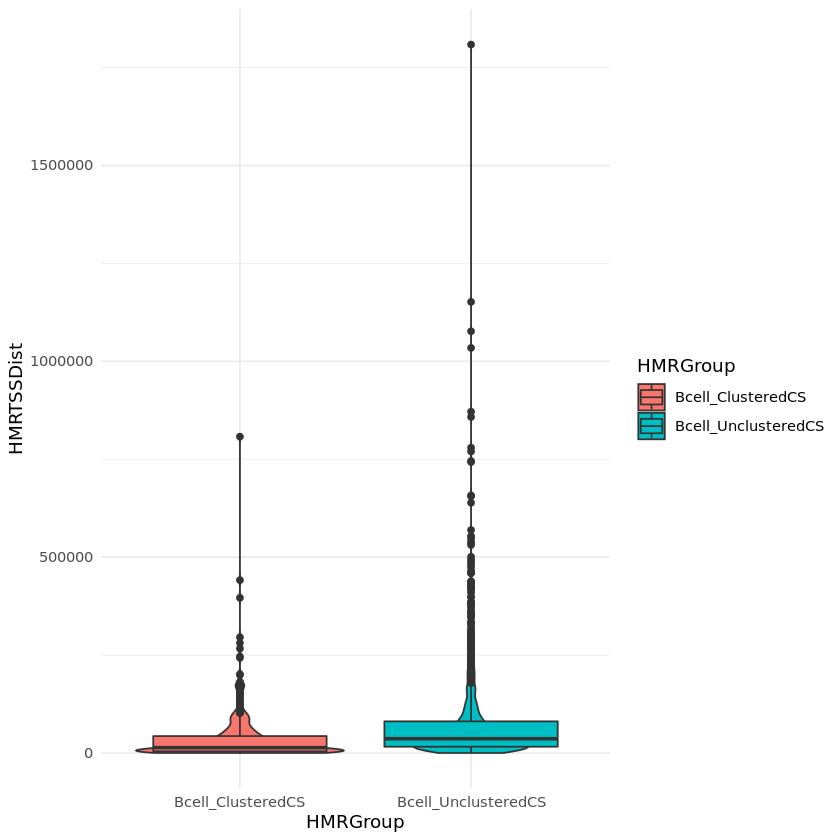

In [49]:
both_noTPMFilter_1NN %>% 
ggplot(aes(x = HMRGroup, y = HMRTSSDist, fill = HMRGroup)) +
geom_violin() +
geom_boxplot() +
theme_minimal()

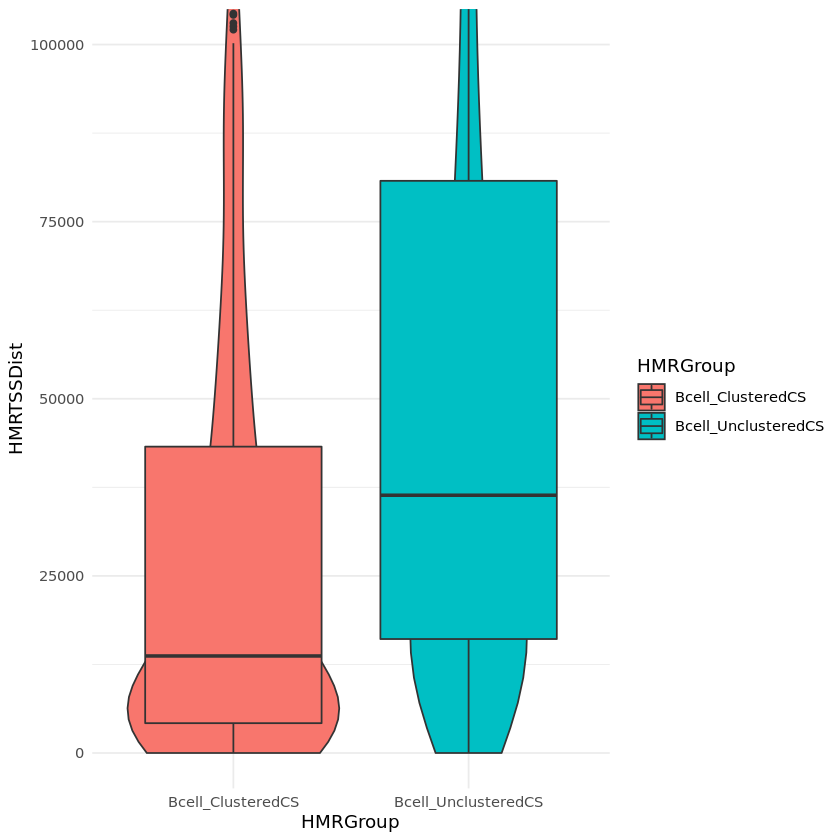

In [50]:
both_noTPMFilter_1NN %>% 
ggplot(aes(x = HMRGroup, y = HMRTSSDist, fill = HMRGroup)) +
geom_violin() +
geom_boxplot() +
theme_minimal() +
coord_cartesian(ylim = c(0, 100000))

In [44]:
wilcox.test(Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.1NN$HMRTSSDist, Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.1NN$HMRTSSDist)


	Wilcoxon rank sum test with continuity correction

data:  Bcell_clusters_containsCS.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.1NN$HMRTSSDist and Bcell_unclustered_cellspecific.100NN.GM_ENSGnoVersionGENESYMBOL_NoTPMFilter_TSS.TAD_filtered.1NN$HMRTSSDist
W = 206438, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


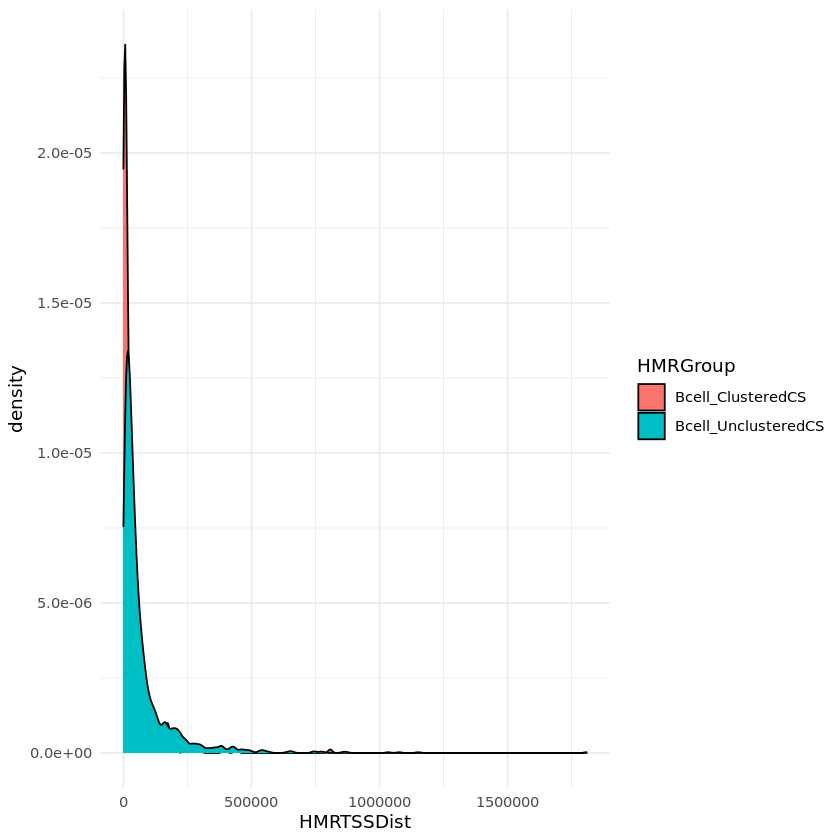

In [51]:
both_noTPMFilter_1NN %>% 
ggplot(aes(x = HMRTSSDist, fill = HMRGroup)) +
geom_density() +
theme_minimal()

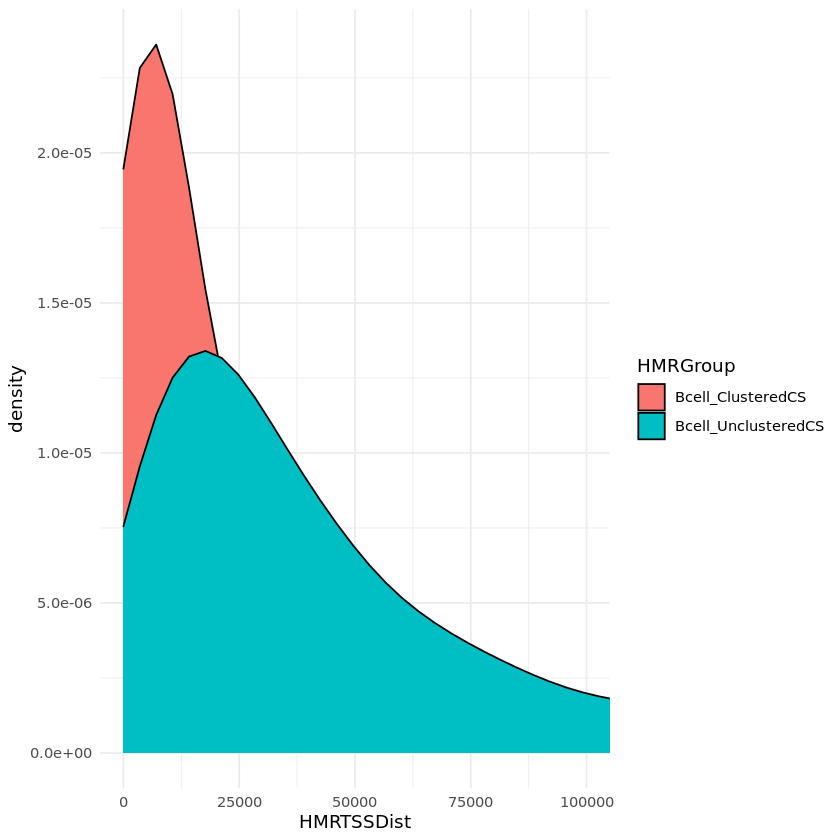

In [52]:
both_noTPMFilter_1NN %>% 
ggplot(aes(x = HMRTSSDist, fill = HMRGroup)) +
geom_density() +
theme_minimal() +
coord_cartesian(xlim = c(0, 100000))

## Plot

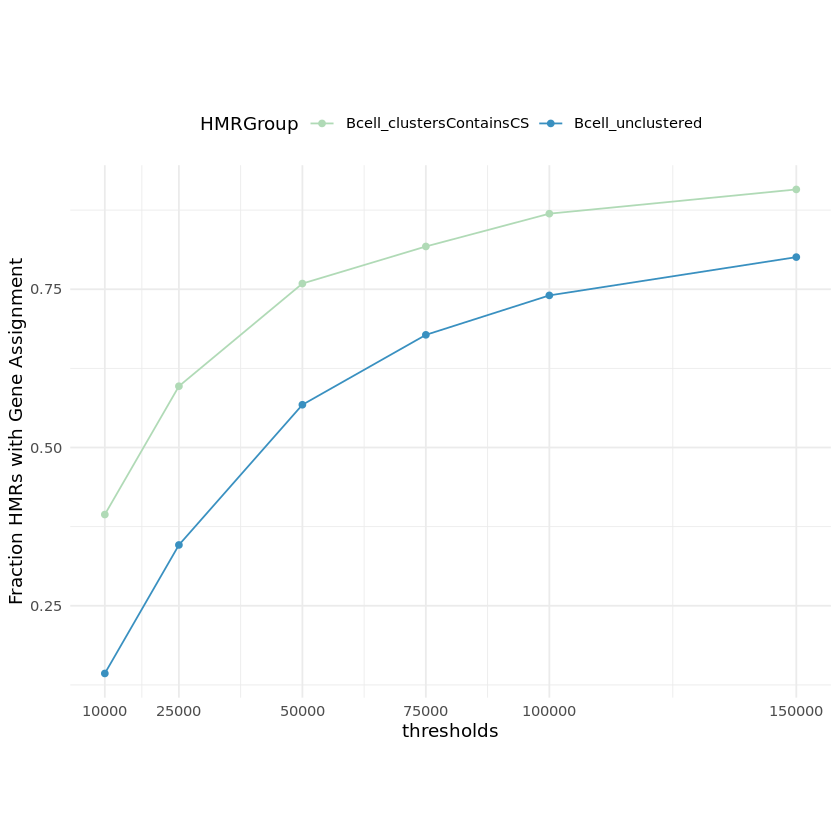

In [79]:
p_numGene_NoTPMFilter_1NN <- numGene_CLcontainsCS_UNCS_NoTPMFilter_1NN_fraction %>%
ggplot(aes(x = thresholds, y = fraction)) +
geom_point(aes(color = HMRGroup)) + 
geom_line(aes(color = HMRGroup)) +
theme_minimal() +
scale_color_manual(values=c("#B0DAB6", "#3990C0")) +
theme(aspect.ratio = .7, legend.position = "top") +
scale_x_continuous(breaks=threshold_list) +
ylab("Fraction HMRs with Gene Assignment")
p_numGene_NoTPMFilter_1NN

In [ ]:
## Fraction of fractions

In [81]:
numGene_CLcontainsCS_UNCS_NoTPMFilter_1NN_fractionRatio <- merge(numGene_CLcontainsCS_NoTPMFilter_1NN_fraction, numGene_UNCS_NoTPMFilter_1NN_fraction, by = "thresholds") %>% mutate(fractionRatio = (fraction.x/fraction.y))

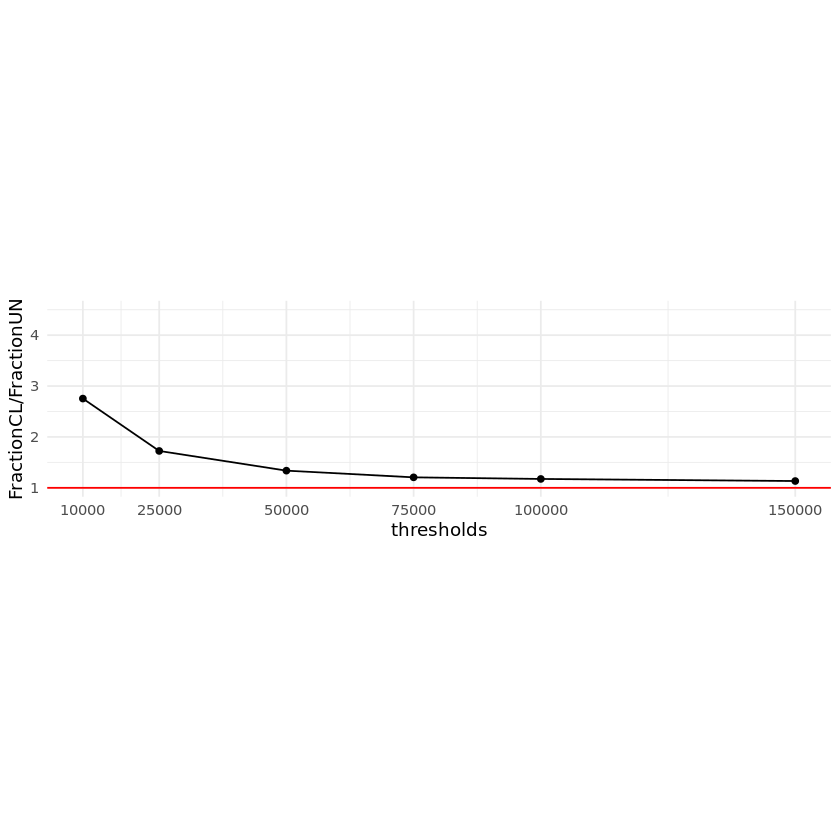

In [82]:
p_numGeneFraction_NoTPMFilter_1NN <- numGene_CLcontainsCS_UNCS_NoTPMFilter_1NN_fractionRatio %>% 
ggplot(aes(x = thresholds, y = fractionRatio)) +
geom_point() + 
geom_line() +
geom_hline(yintercept = 1, color = "red") + 
coord_cartesian(ylim = c(1,4.5)) +
theme_minimal() +
scale_x_continuous(breaks=threshold_list) + 
theme(aspect.ratio = .25) +
ylab("FractionCL/FractionUN")

p_numGeneFraction_NoTPMFilter_1NN

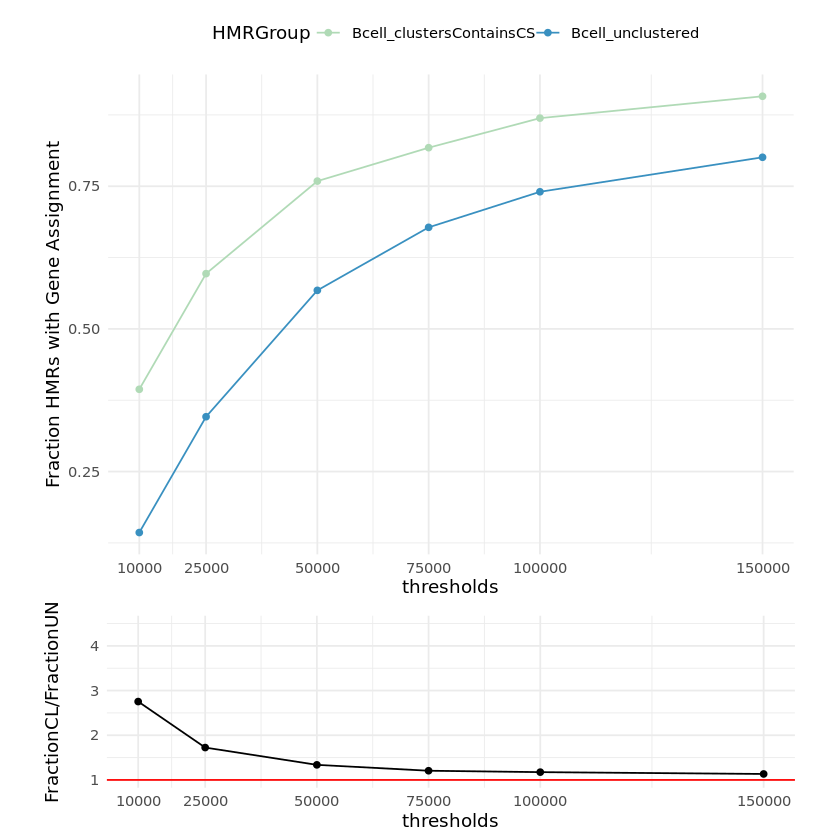

In [83]:
ggpubr::ggarrange(p_numGene_NoTPMFilter_1NN, p_numGeneFraction_NoTPMFilter_1NN, nrow = 2, align = "v", heights = c(4, 1.539))

## Stats for fractions

In [84]:
head(numGene_CLcontainsCS_UNCS_NoTPMFilter_1NN_fractionRatio, 3)

,thresholds,HMRGroup.x,HMRCounts.x,fraction.x,HMRGroup.y,HMRCounts.y,fraction.y,fractionRatio
,<dbl>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
1,10000,Bcell_clustersContainsCS,175,0.3941441,Bcell_unclustered,232,0.1431215,2.753912
2,25000,Bcell_clustersContainsCS,265,0.5968468,Bcell_unclustered,561,0.3460827,1.724579
3,50000,Bcell_clustersContainsCS,337,0.7590090,Bcell_unclustered,920,0.5675509,1.337341


In [85]:
numGene_CLcontainsCS_UNCS_NoTPMFilter_1NN_fractionRatio

thresholds,HMRGroup.x,HMRCounts.x,fraction.x,HMRGroup.y,HMRCounts.y,fraction.y,fractionRatio
<dbl>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
10000,Bcell_clustersContainsCS,175,0.3941441,Bcell_unclustered,232,0.1431215,2.753912
25000,Bcell_clustersContainsCS,265,0.5968468,Bcell_unclustered,561,0.3460827,1.724579
50000,Bcell_clustersContainsCS,337,0.7590090,Bcell_unclustered,920,0.5675509,1.337341
75000,Bcell_clustersContainsCS,363,0.8175676,Bcell_unclustered,1099,0.6779766,1.205894
100000,Bcell_clustersContainsCS,386,0.8693694,Bcell_unclustered,1200,0.7402838,1.174373
150000,Bcell_clustersContainsCS,403,0.9076577,Bcell_unclustered,1298,0.8007403,1.133523


In [88]:
numGene_CLcontainsCS_UNCS_NoTPMFilter_1NN_fractionRatio_pvals <- numGene_CLcontainsCS_UNCS_NoTPMFilter_1NN_fractionRatio %>% rowwise() %>% mutate(
    propTestP = prop.test(x = c(HMRCounts.x, HMRCounts.y), n = c(444, 1621))$p.value,
    propTestStat = prop.test(x = c(HMRCounts.x, HMRCounts.y), n = c(444, 1621))$statistic,
)
numGene_CLcontainsCS_UNCS_NoTPMFilter_1NN_fractionRatio_pvals 

thresholds,HMRGroup.x,HMRCounts.x,fraction.x,HMRGroup.y,HMRCounts.y,fraction.y,fractionRatio,propTestP,propTestStat
<dbl>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
10000,Bcell_clustersContainsCS,175,0.3941441,Bcell_unclustered,232,0.1431215,2.753912,1.090224e-31,137.20017
25000,Bcell_clustersContainsCS,265,0.5968468,Bcell_unclustered,561,0.3460827,1.724579,2.069310e-21,90.27809
50000,Bcell_clustersContainsCS,337,0.7590090,Bcell_unclustered,920,0.5675509,1.337341,3.620494e-13,52.83895
75000,Bcell_clustersContainsCS,363,0.8175676,Bcell_unclustered,1099,0.6779766,1.205894,1.406504e-08,32.17834
100000,Bcell_clustersContainsCS,386,0.8693694,Bcell_unclustered,1200,0.7402838,1.174373,1.641361e-08,31.87835
150000,Bcell_clustersContainsCS,403,0.9076577,Bcell_unclustered,1298,0.8007403,1.133523,2.366228e-07,26.70814


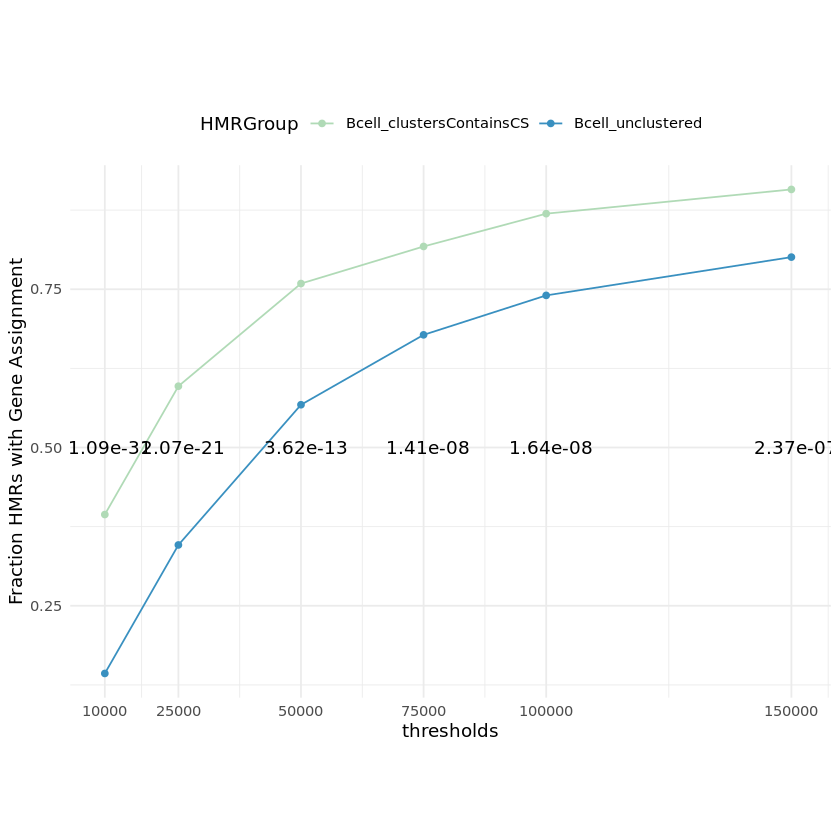

In [89]:
p_numGene_NoTPMFilter_1NN_stats <- p_numGene_NoTPMFilter_1NN +
geom_text(data = numGene_CLcontainsCS_UNCS_NoTPMFilter_1NN_fractionRatio_pvals, aes(x = thresholds+1000, y = .5, label = format(propTestP, digits=3)))
p_numGene_NoTPMFilter_1NN_stats

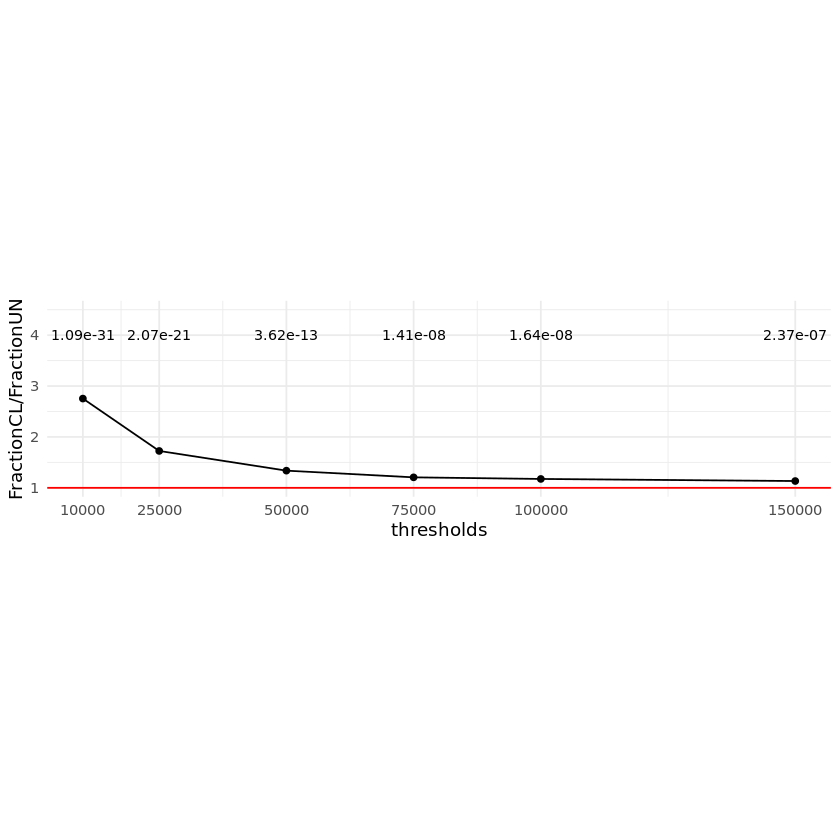

In [90]:
p_numGeneFraction_NoTPMFilter_1NN +
geom_text(data = numGene_CLcontainsCS_UNCS_NoTPMFilter_1NN_fractionRatio_pvals, aes(x = thresholds, y = 4, label = format(propTestP, digits=3)), size = 3)

In [94]:
prop.test(x = c(2, 27), n = c(406, 1507))


	2-sample test for equality of proportions with continuity correction

data:  c(2, 27) out of c(406, 1507)
X-squared = 2.7973, df = 1, p-value = 0.09442
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.024105131 -0.001875432
sample estimates:
     prop 1      prop 2 
0.004926108 0.017916390 


In [95]:
prop.test(x = c(2, 27), n = c(444, 1621))


	2-sample test for equality of proportions with continuity correction

data:  c(2, 27) out of c(444, 1621)
X-squared = 2.8912, df = 1, p-value = 0.08906
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.02239623 -0.00190753
sample estimates:
     prop 1      prop 2 
0.004504505 0.016656385 
